In [104]:
#!pip3 install --pre pycaret
#from pycaret.regression import setup, compare_models

In [105]:
#!pip install optuna

In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, ElasticNet,  Lasso, LinearRegression,BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train0 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test0 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

Inspected Column: MSSubClass


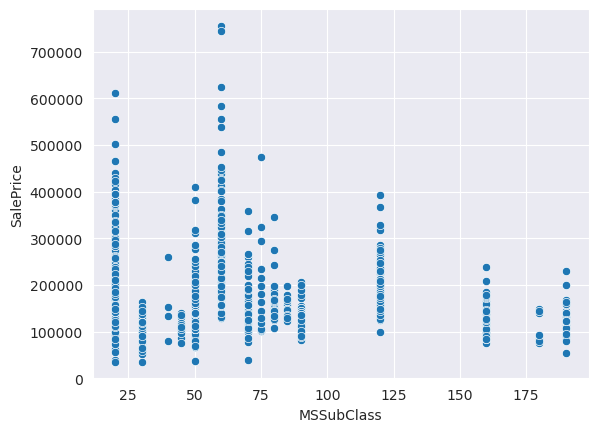

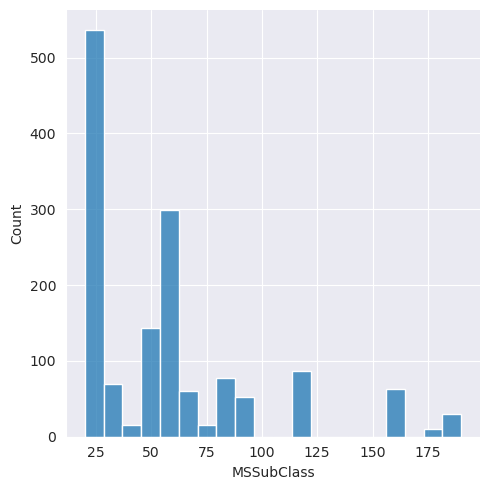

Inspected Column: MSZoning


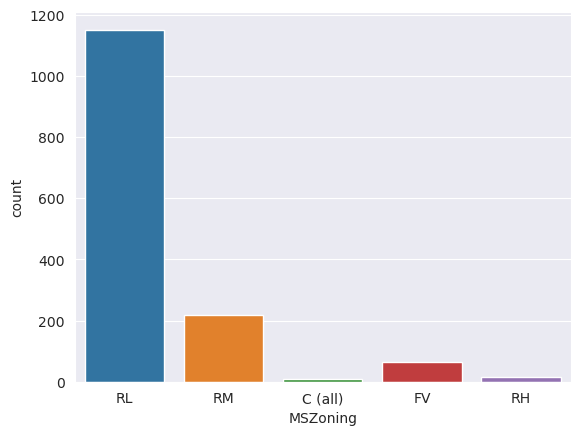

Inspected Column: LotFrontage


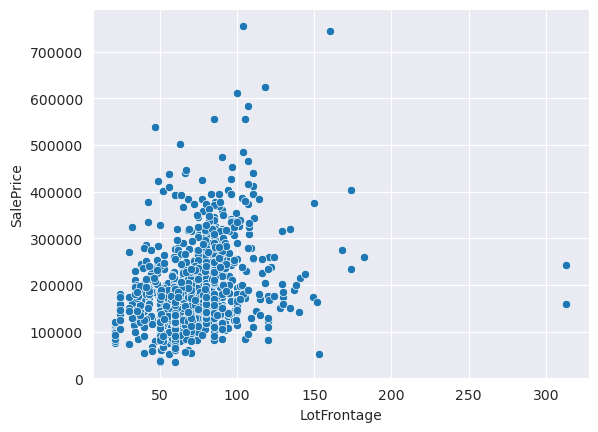

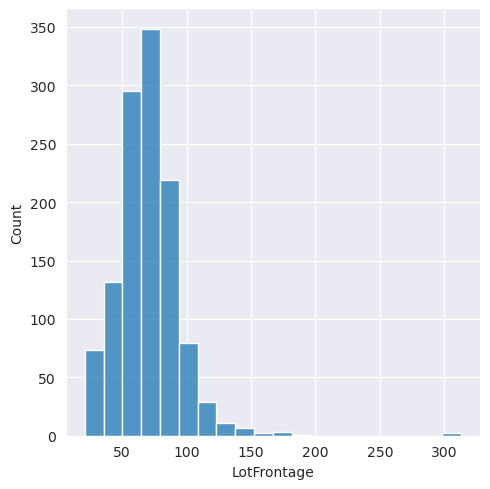

Inspected Column: LotArea


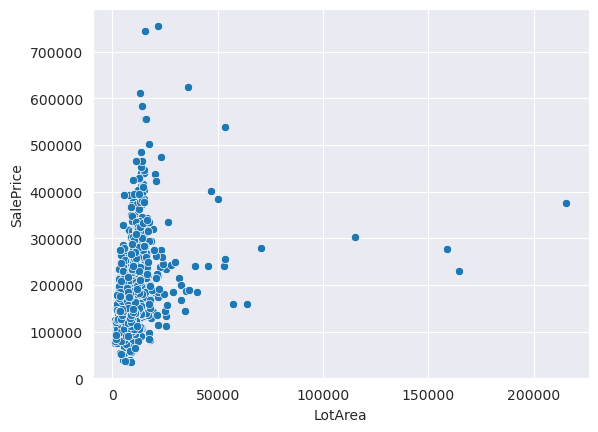

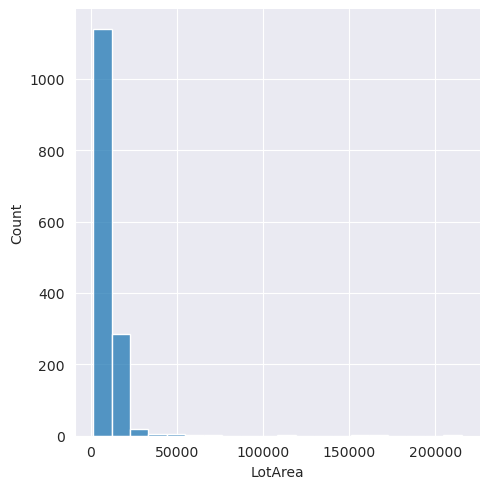

Inspected Column: Street


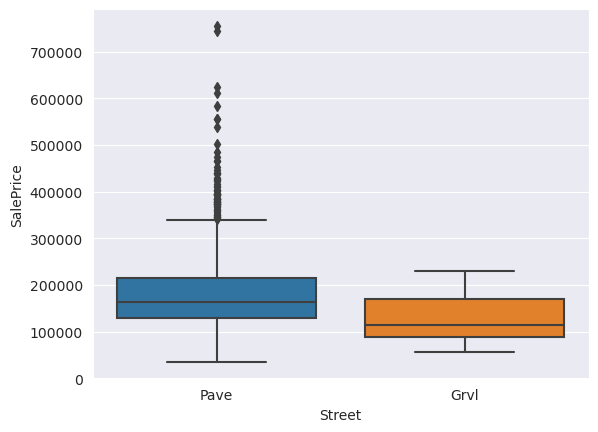

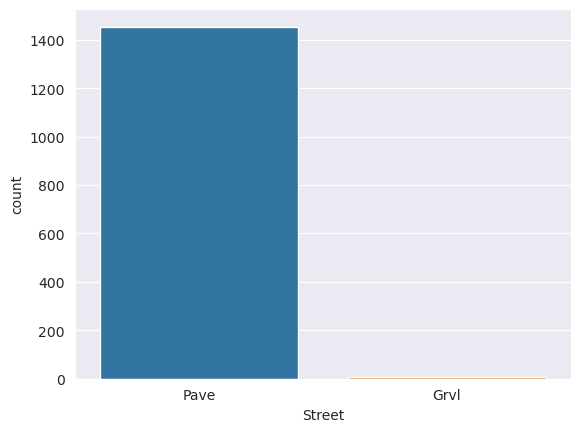

Inspected Column: Alley


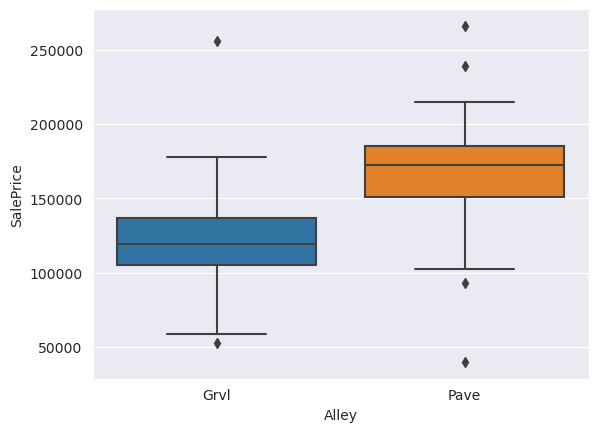

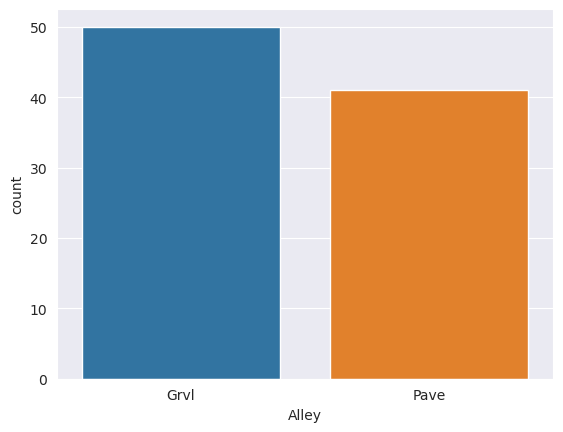

Inspected Column: LotShape


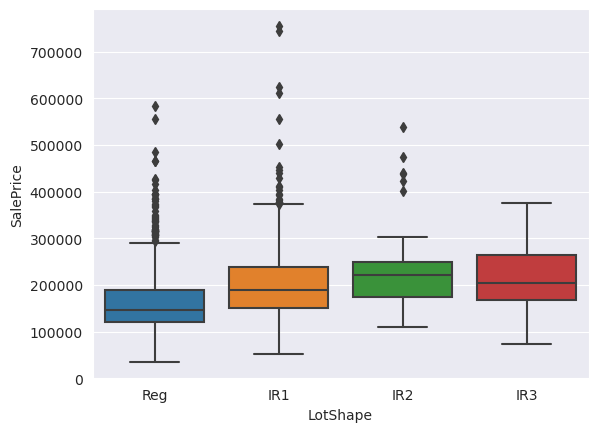

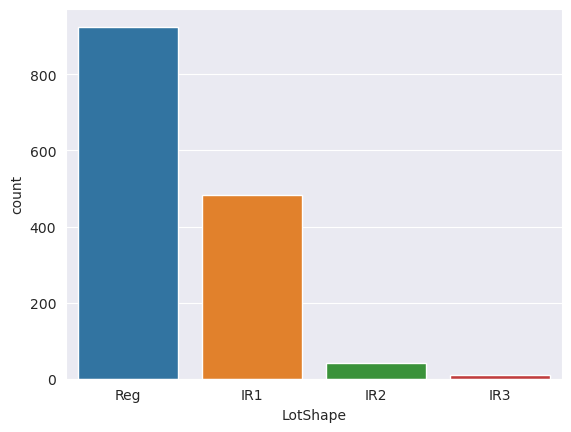

Inspected Column: LandContour


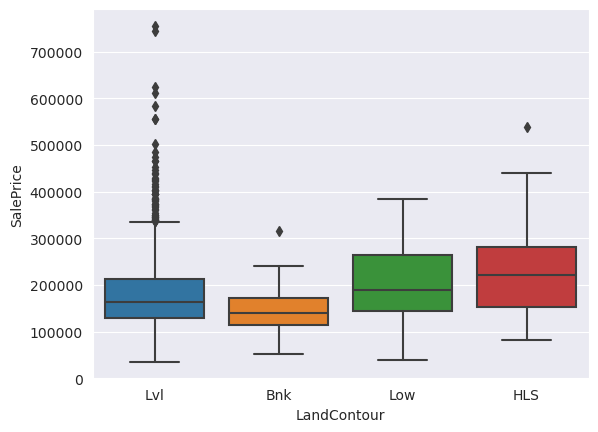

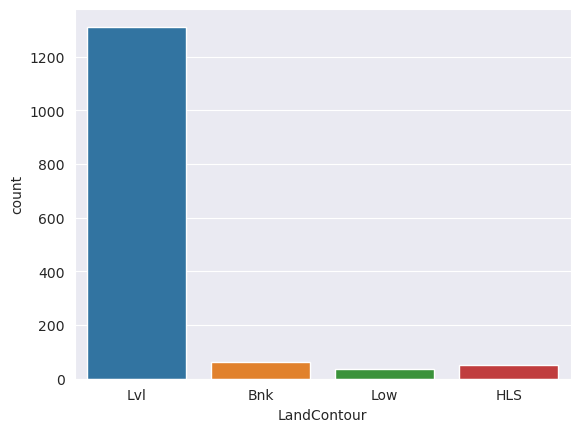

Inspected Column: Utilities


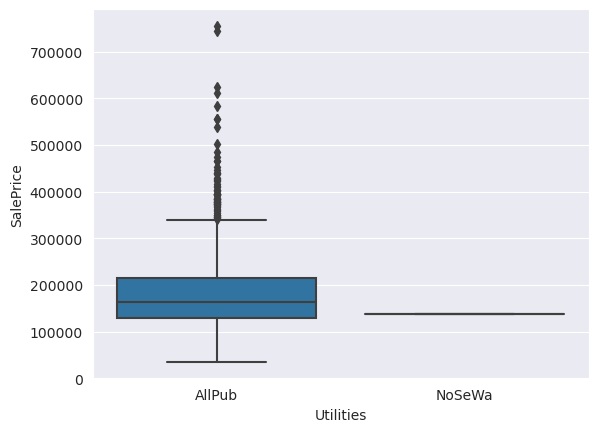

Inspected Column: LotConfig


Inspected Column: LandSlope


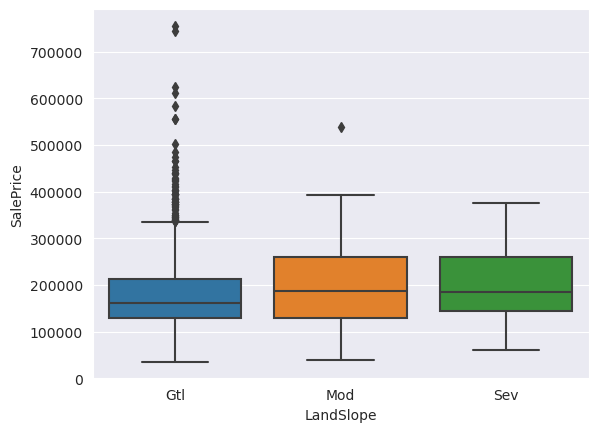

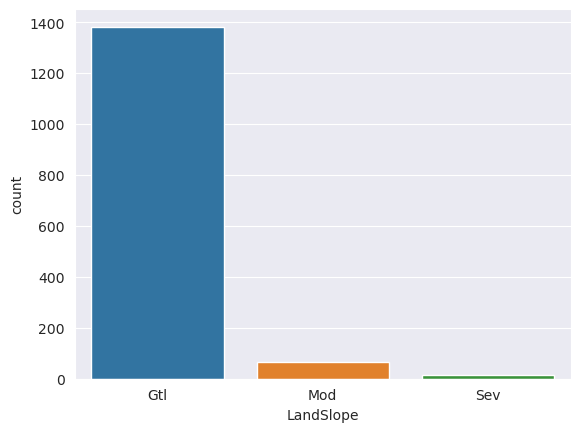

Inspected Column: Neighborhood


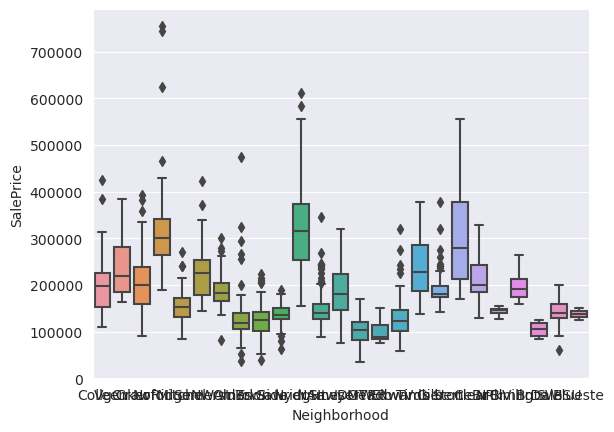

Inspected Column: Condition1


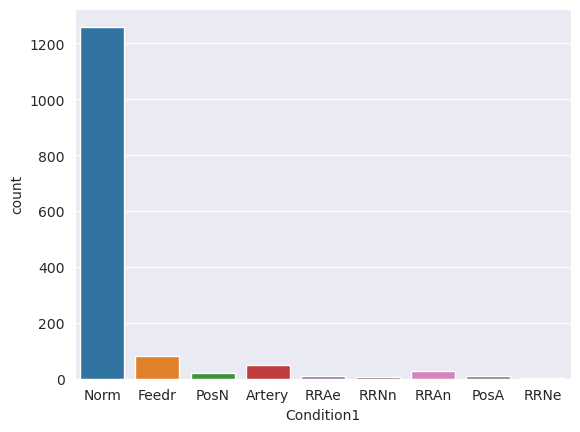

Inspected Column: Condition2


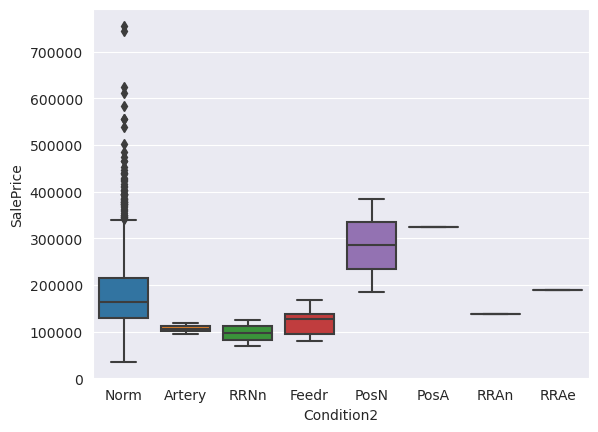

Inspected Column: BldgType


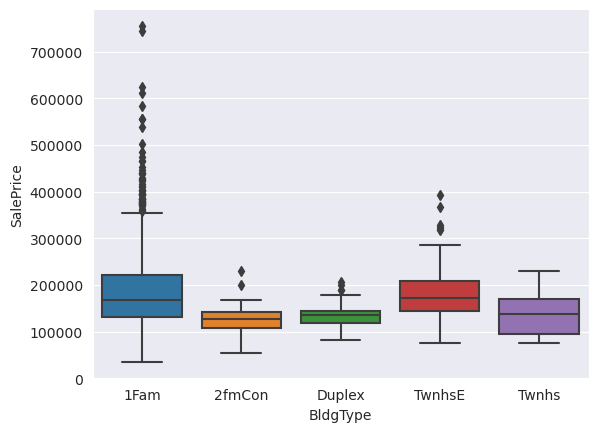

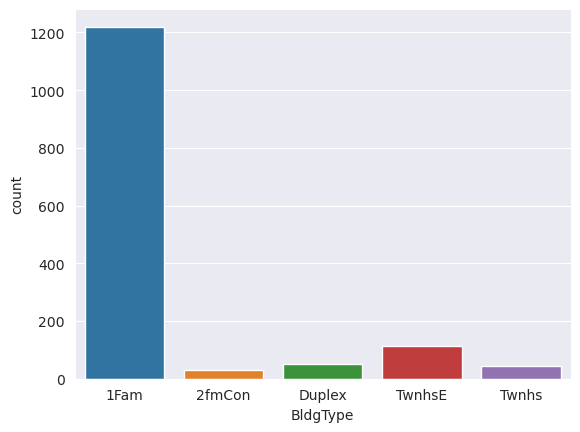

Inspected Column: HouseStyle


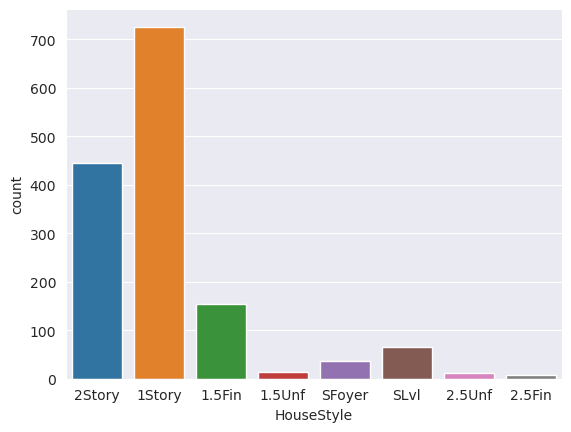

Inspected Column: OverallQual


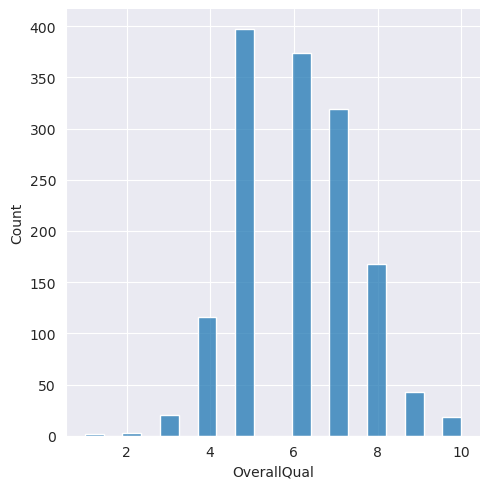

Inspected Column: OverallCond


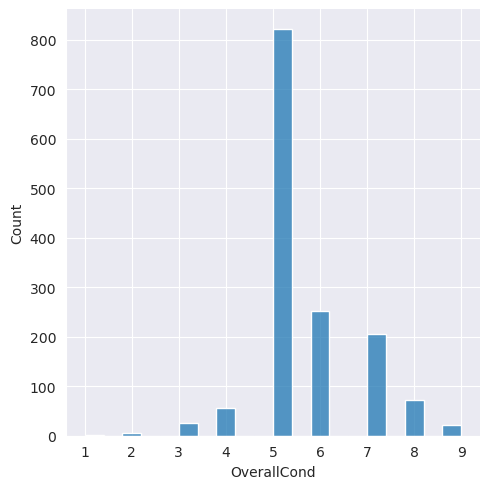

Inspected Column: YearBuilt


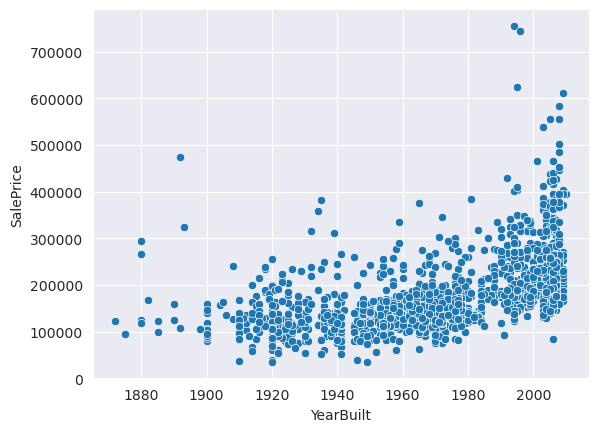

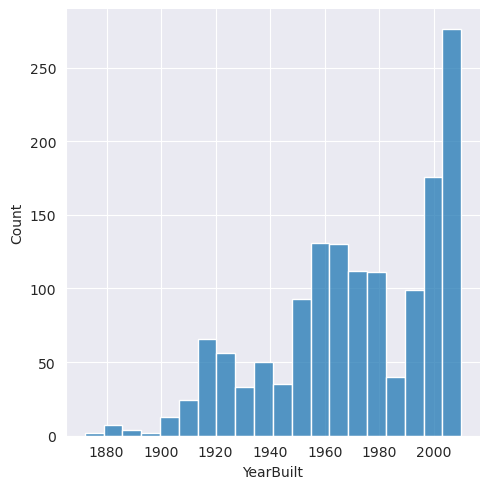

Inspected Column: YearRemodAdd


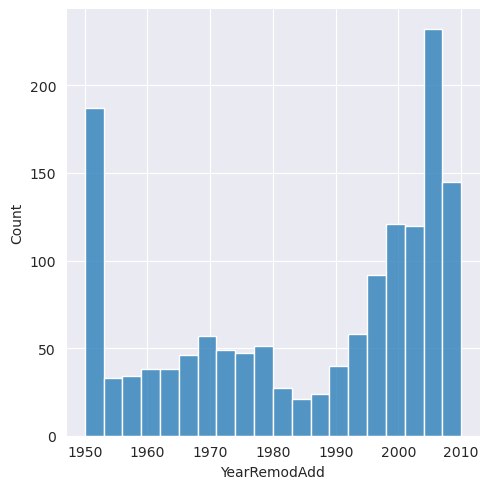

Inspected Column: RoofStyle


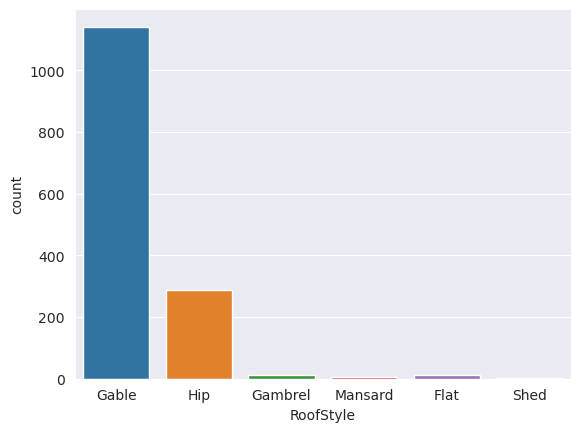

Inspected Column: RoofMatl


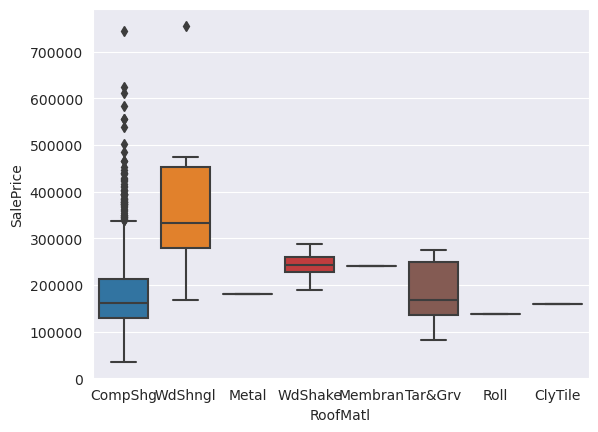

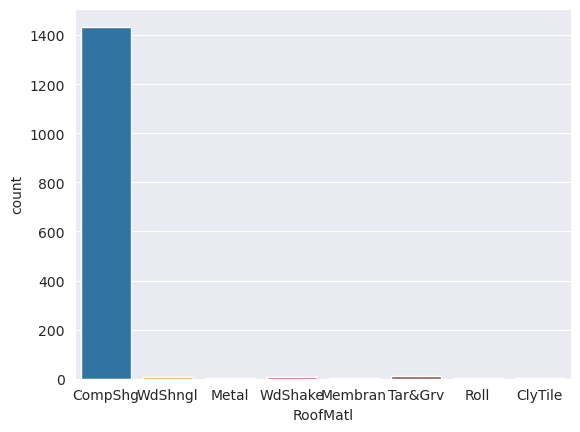

Inspected Column: Exterior1st


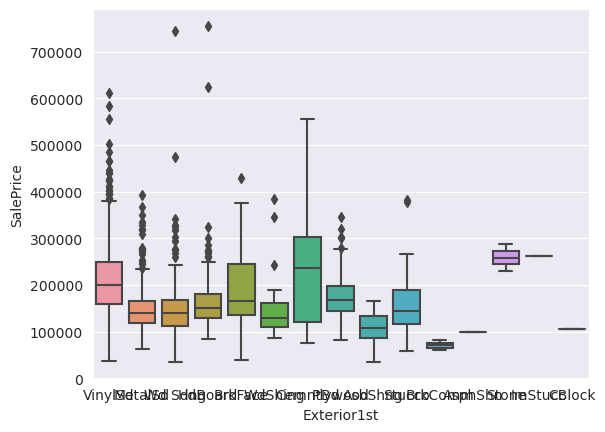

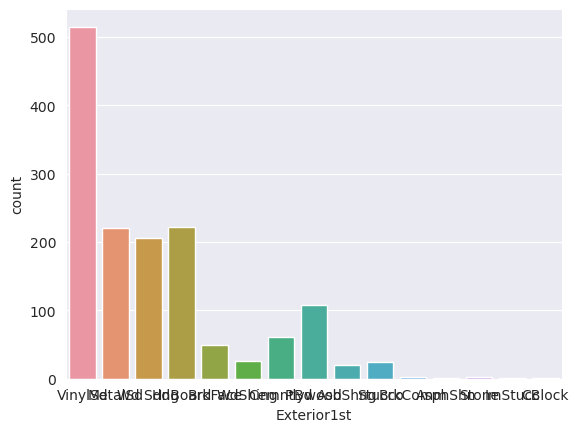

Inspected Column: Exterior2nd


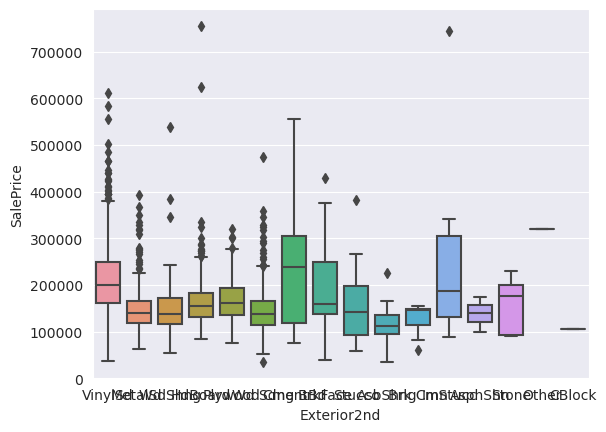

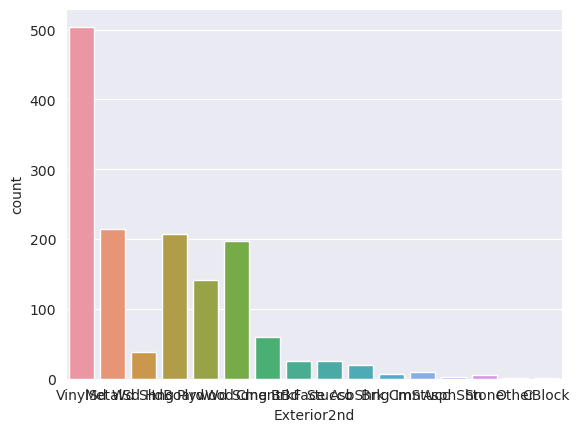

Inspected Column: MasVnrType


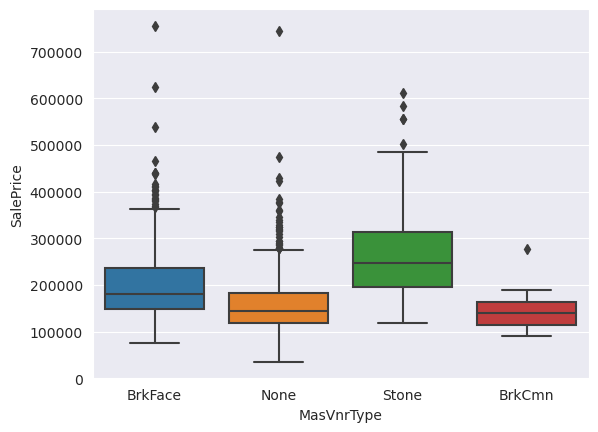

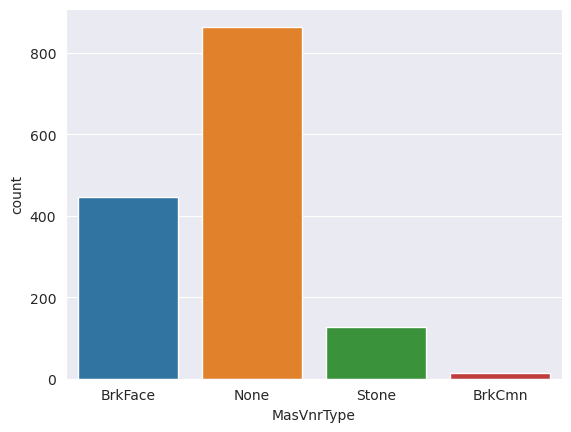

Inspected Column: MasVnrArea


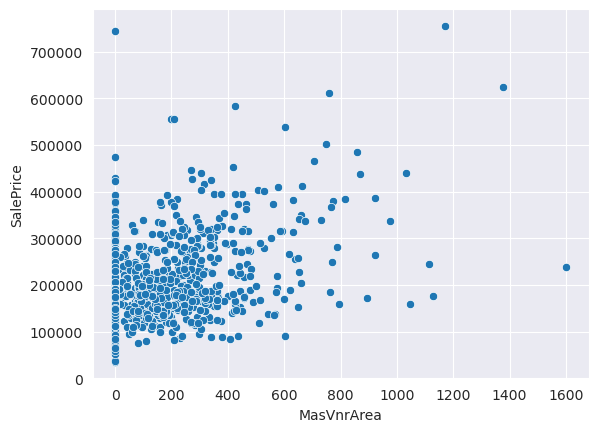

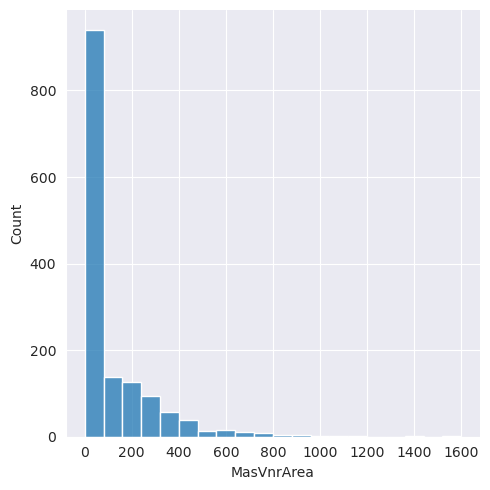

Inspected Column: ExterQual


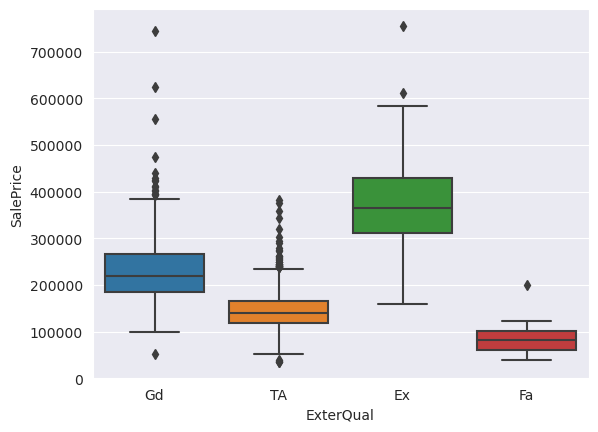

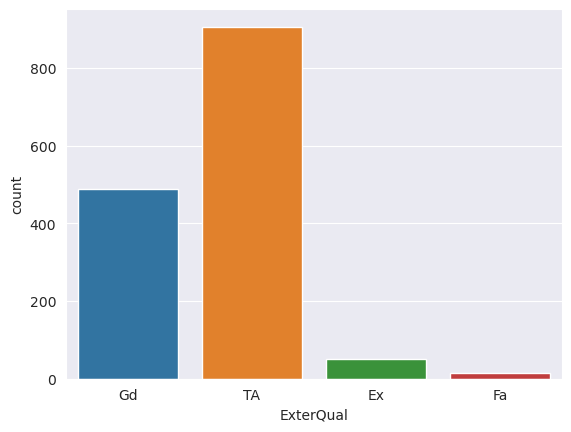

Inspected Column: ExterCond


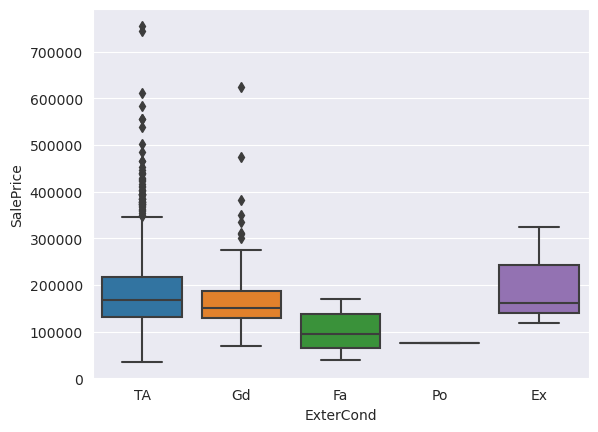

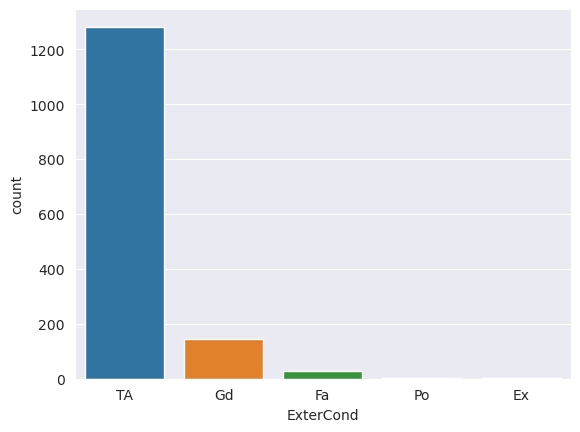

Inspected Column: Foundation


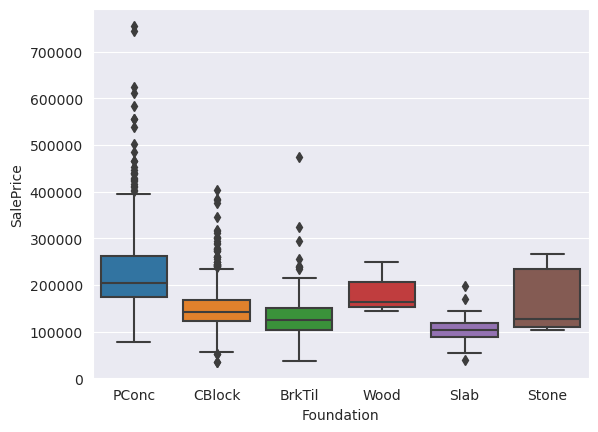

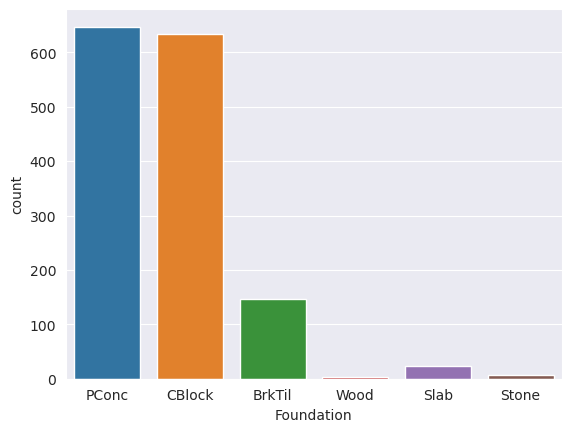

Inspected Column: BsmtQual


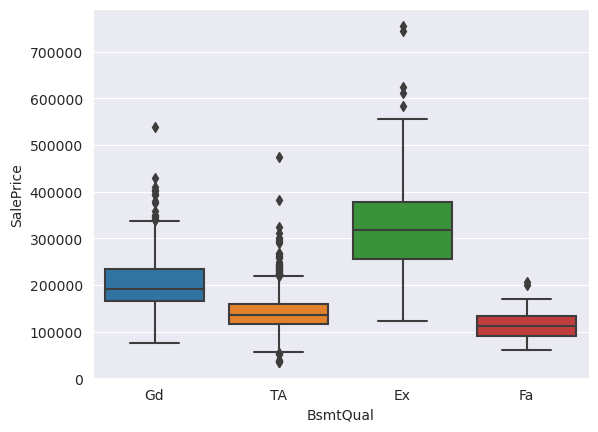

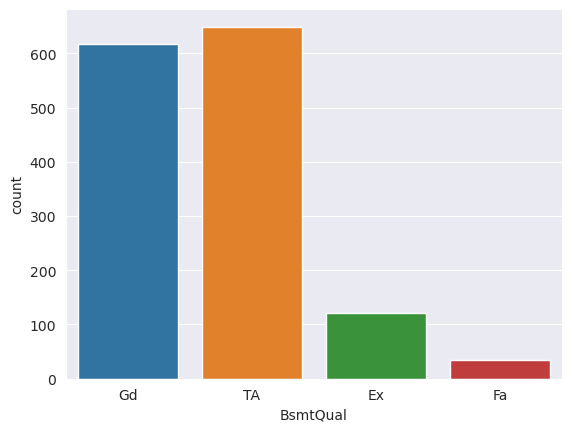

Inspected Column: BsmtCond


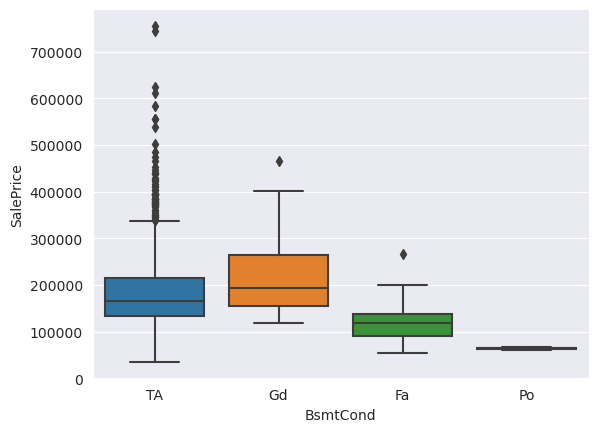

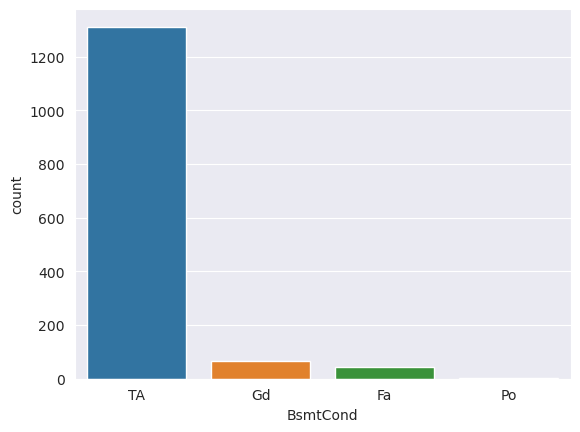

Inspected Column: BsmtExposure


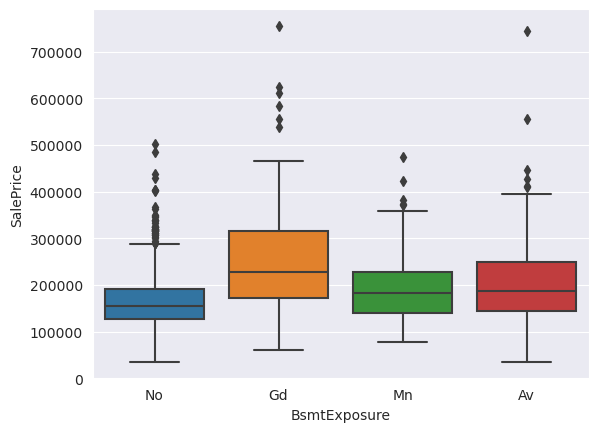

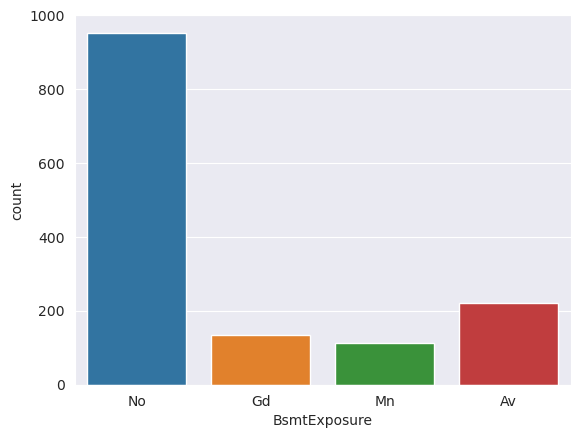

Inspected Column: BsmtFinType1


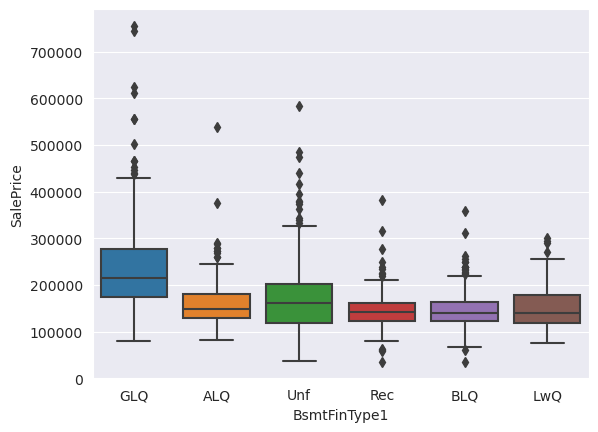

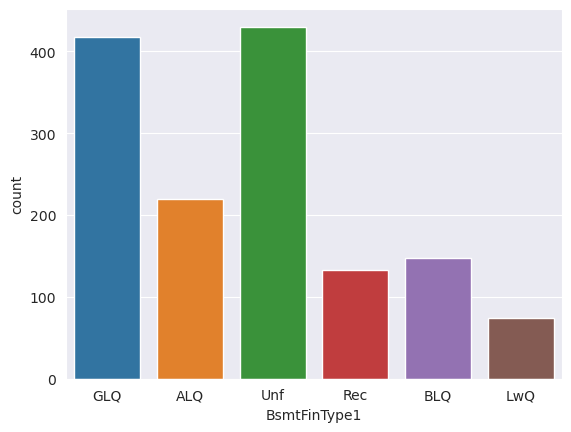

Inspected Column: BsmtFinSF1


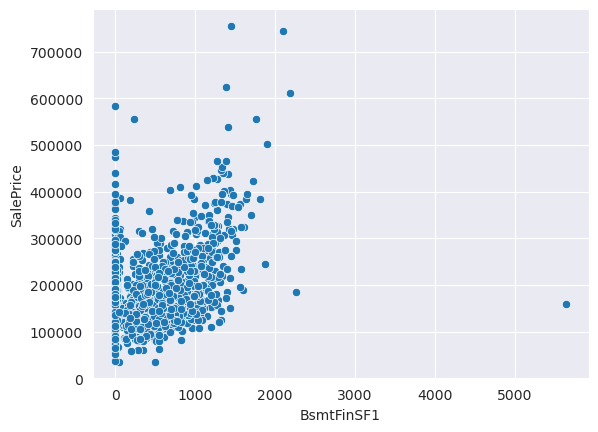

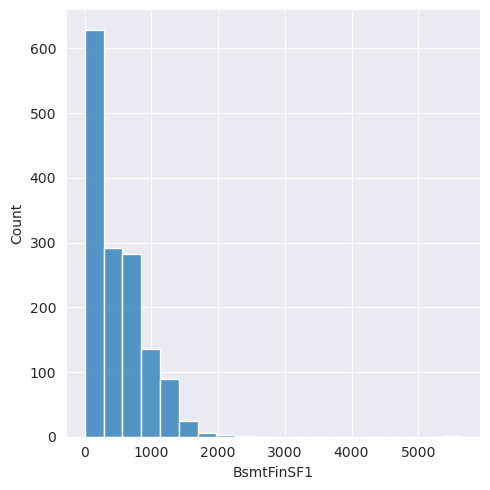

Inspected Column: BsmtFinType2


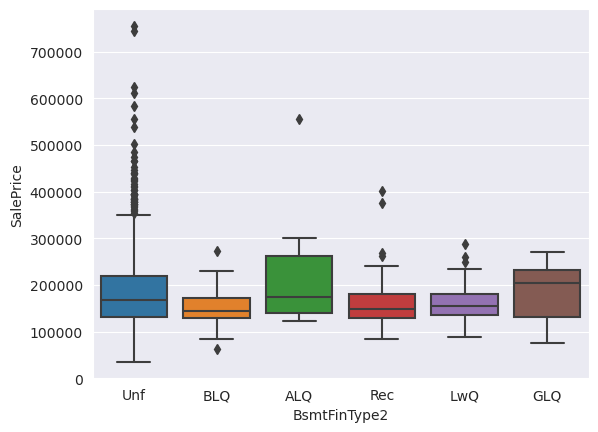

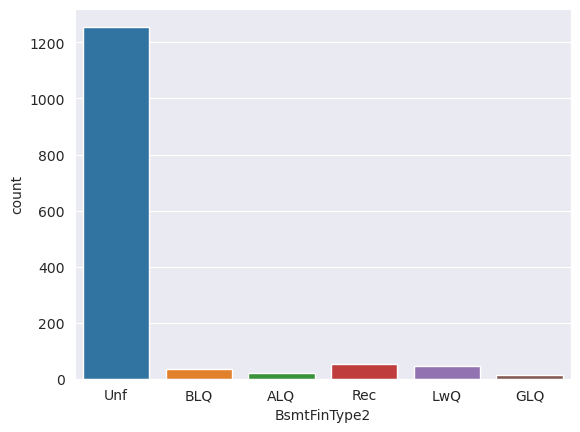

Inspected Column: BsmtFinSF2


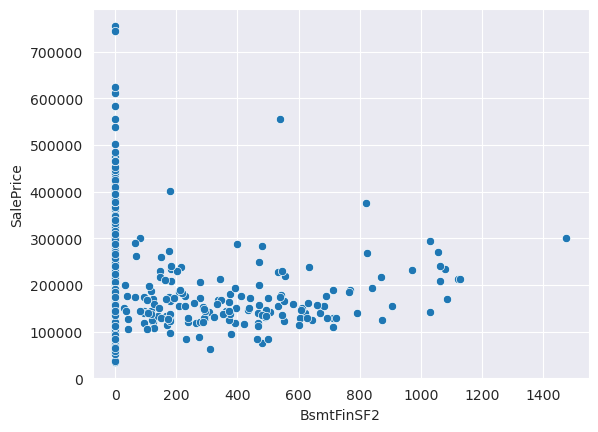

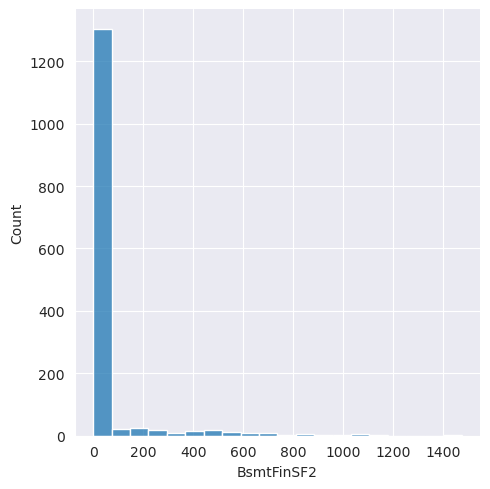

Inspected Column: BsmtUnfSF


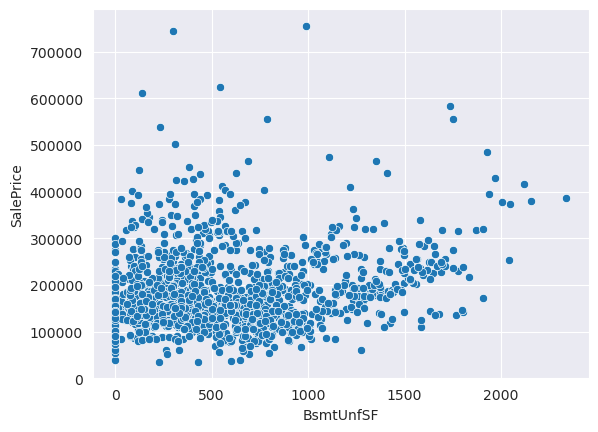

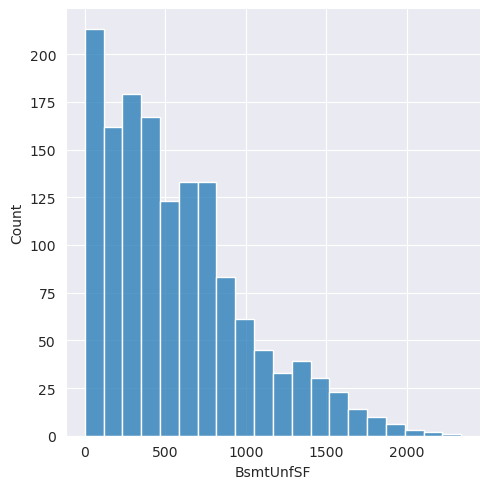

Inspected Column: TotalBsmtSF


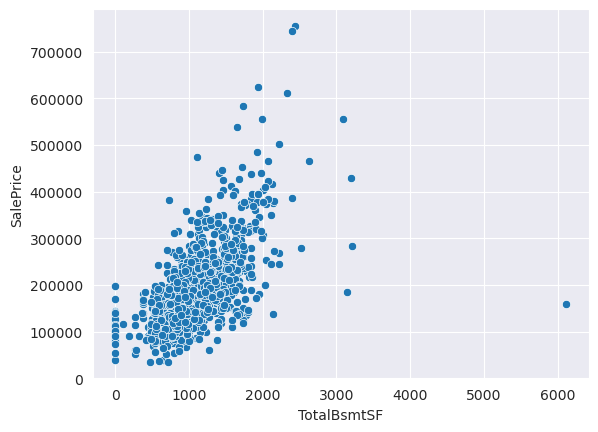

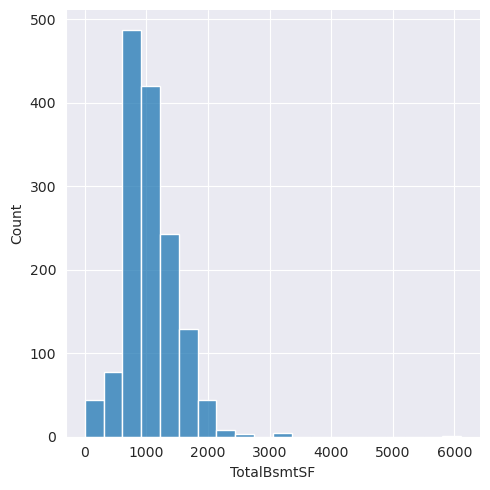

Inspected Column: Heating


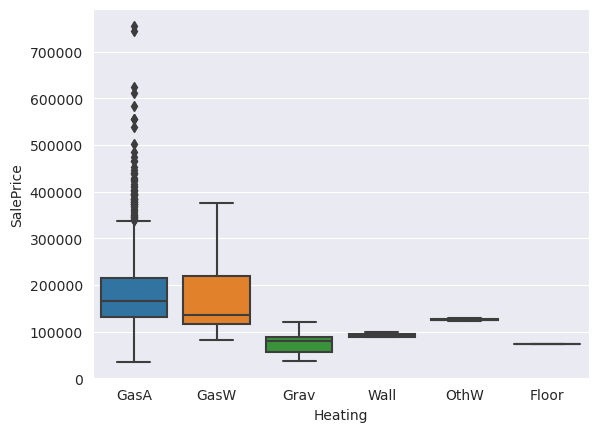

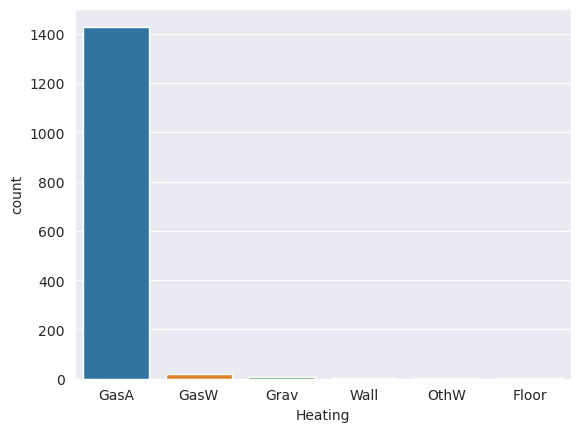

Inspected Column: HeatingQC


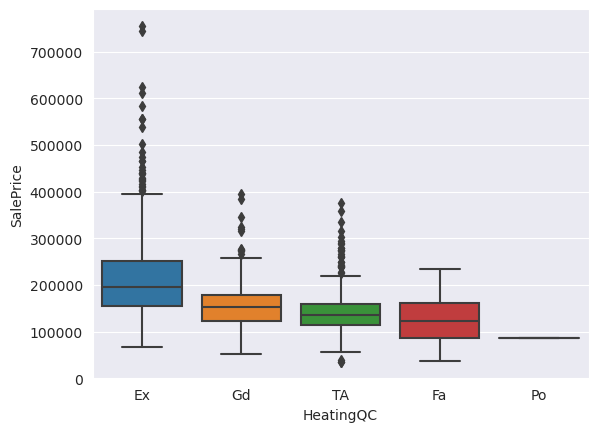

Inspected Column: CentralAir


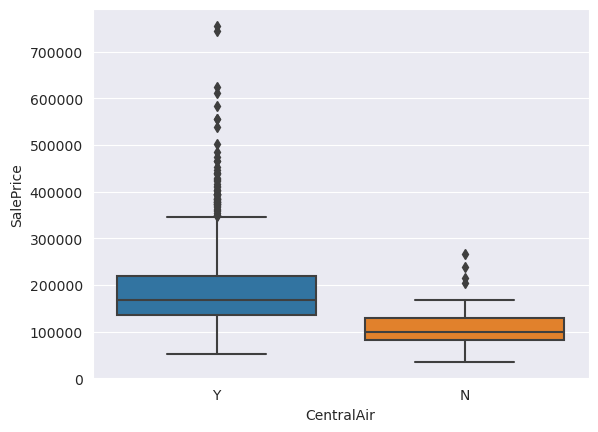

Inspected Column: Electrical


Inspected Column: 1stFlrSF


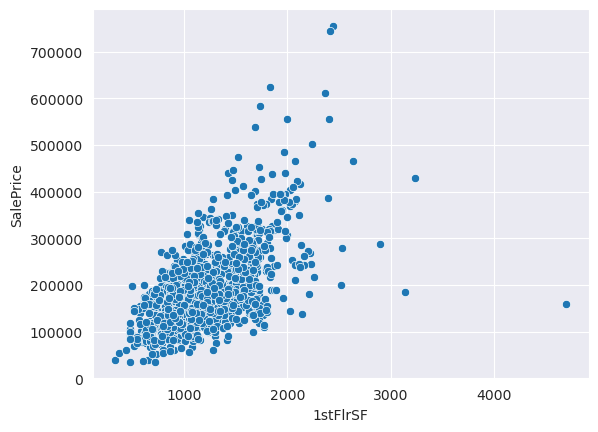

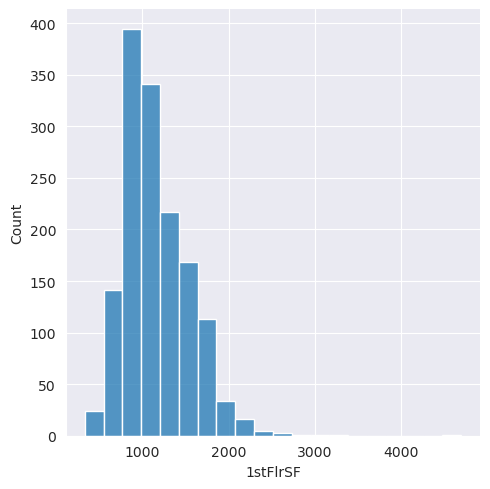

Inspected Column: 2ndFlrSF


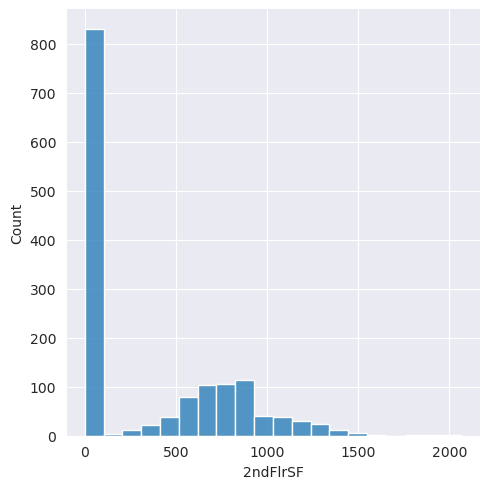

Inspected Column: LowQualFinSF


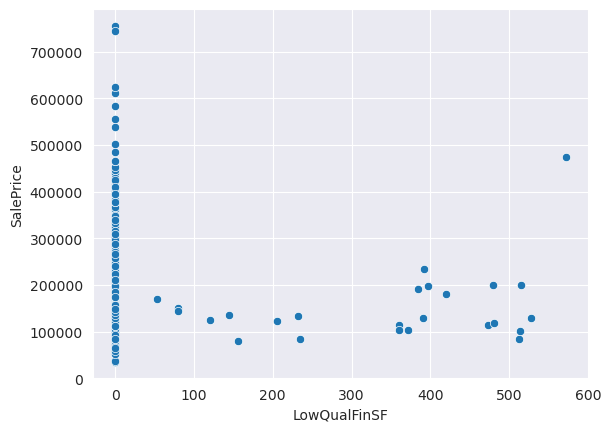

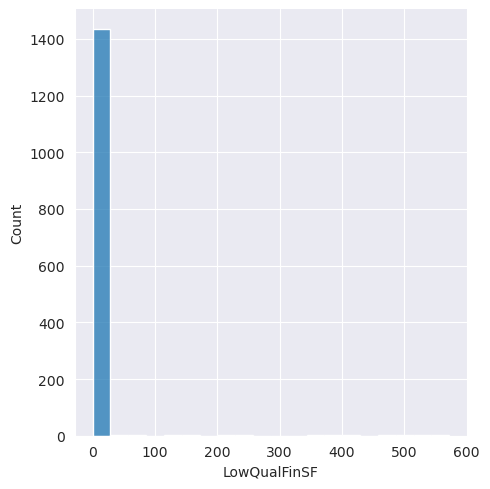

Inspected Column: GrLivArea


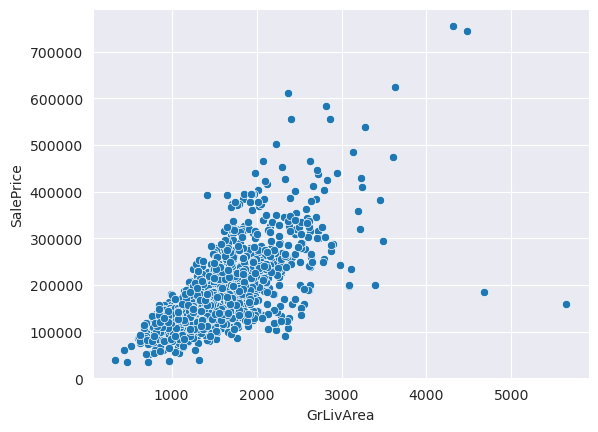

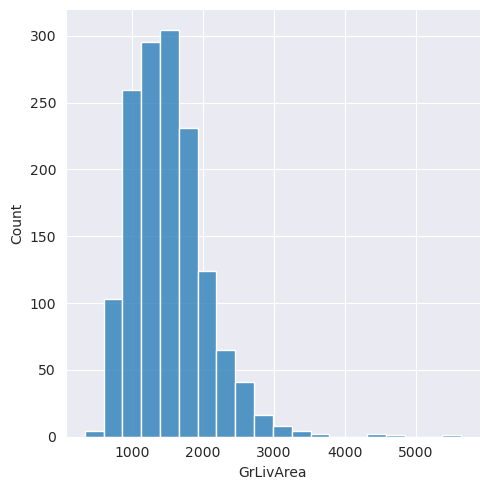

Inspected Column: BsmtFullBath


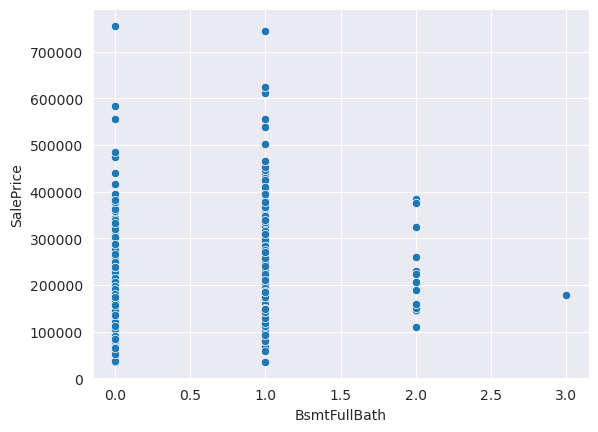

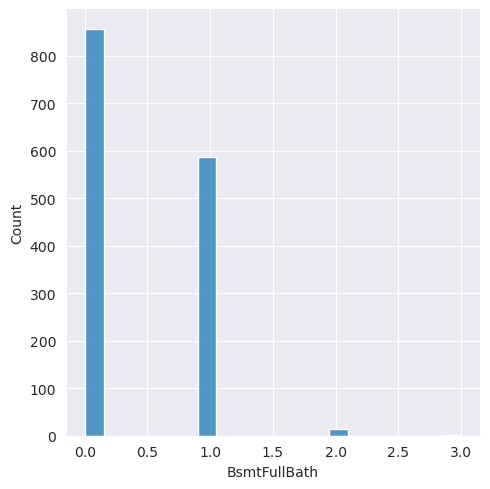

Inspected Column: BsmtHalfBath


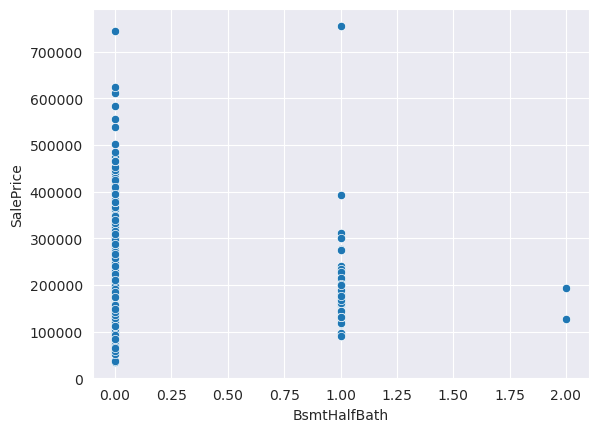

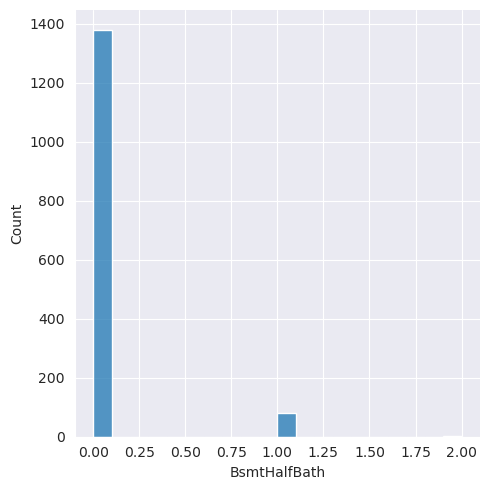

Inspected Column: FullBath


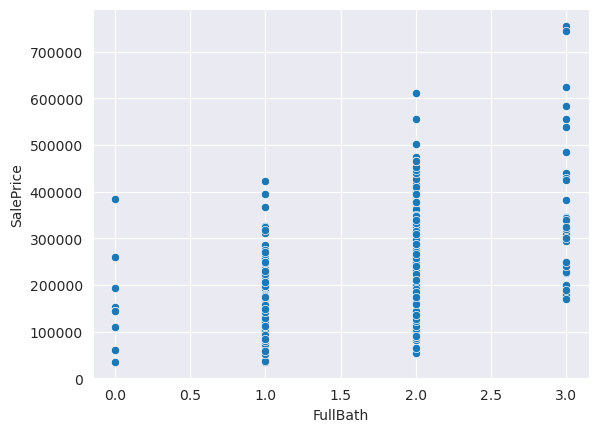

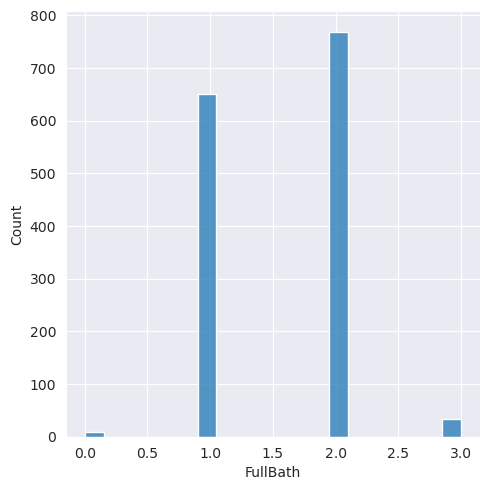

Inspected Column: HalfBath


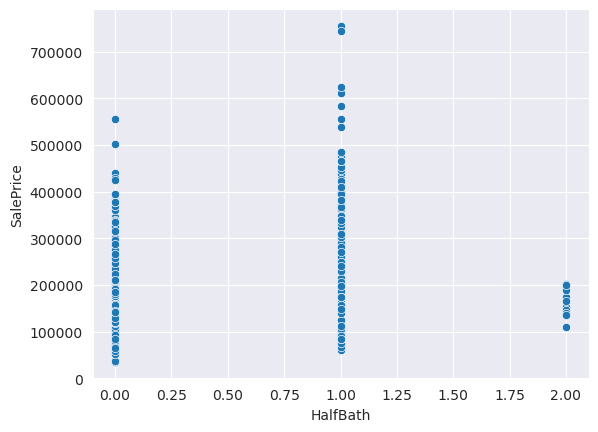

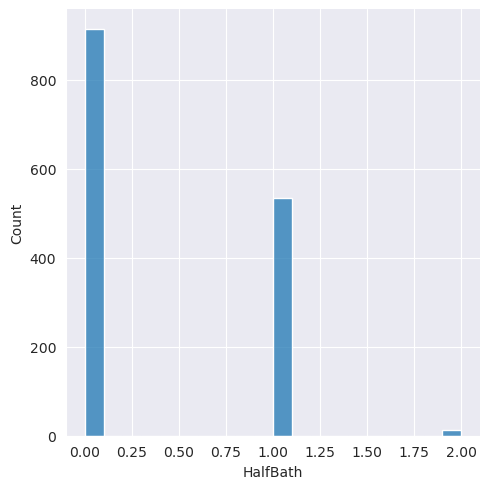

Inspected Column: BedroomAbvGr


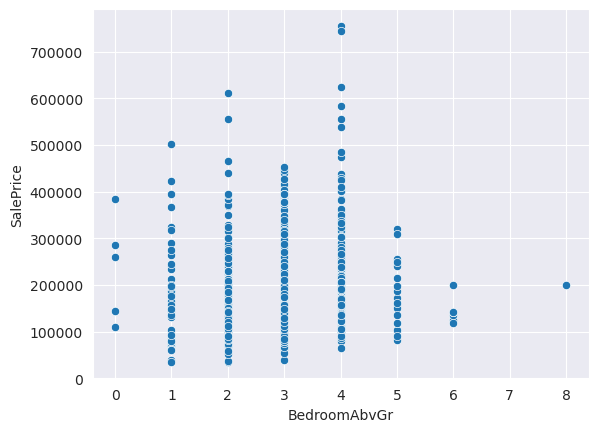

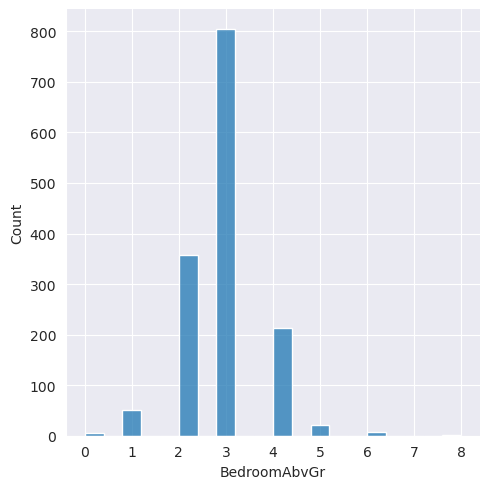

Inspected Column: KitchenAbvGr


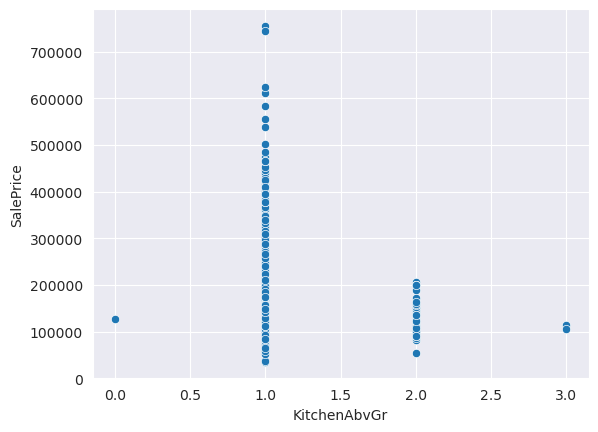

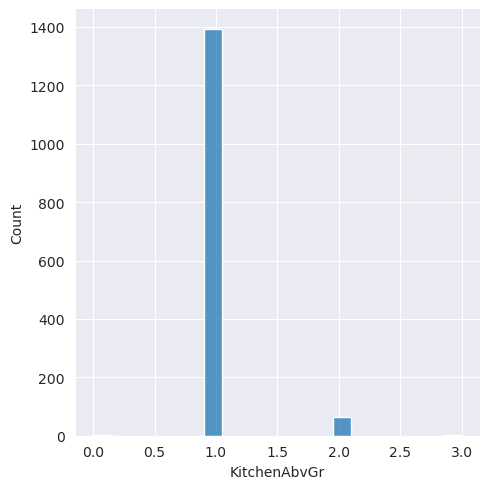

Inspected Column: KitchenQual


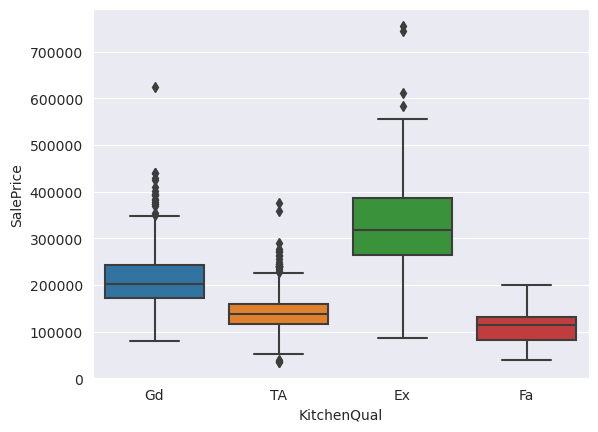

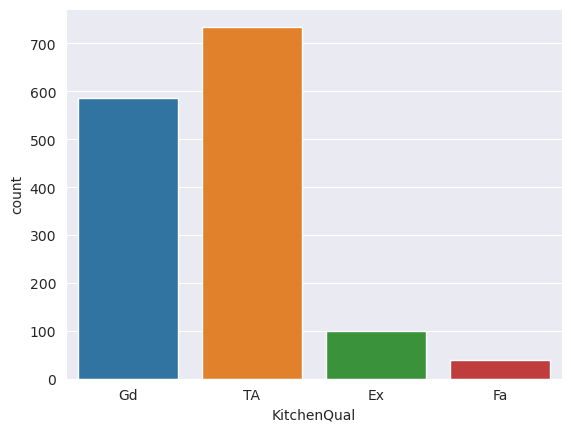

Inspected Column: TotRmsAbvGrd


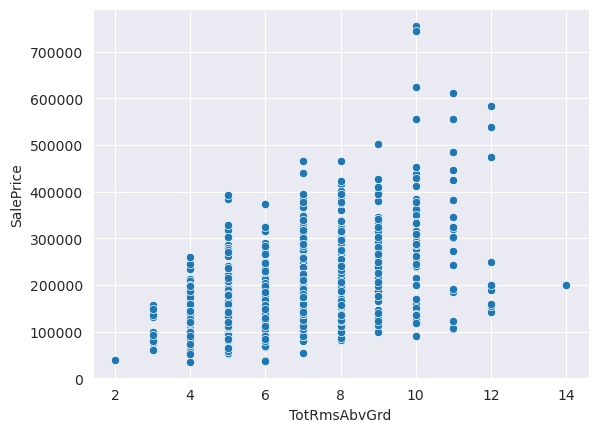

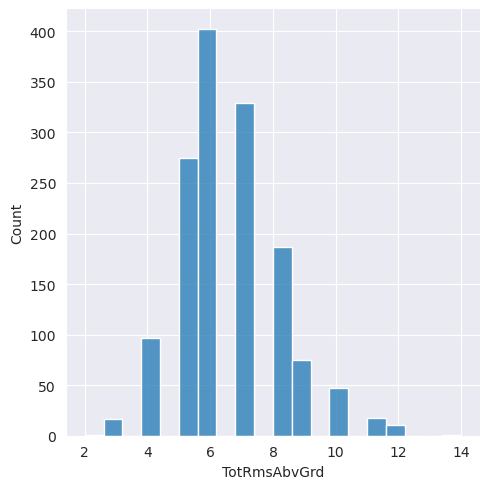

Inspected Column: Functional


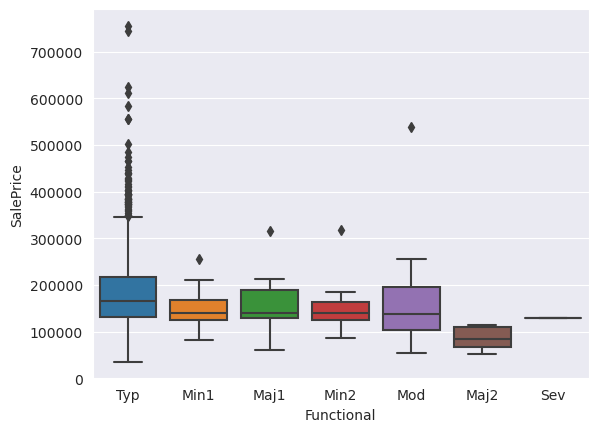

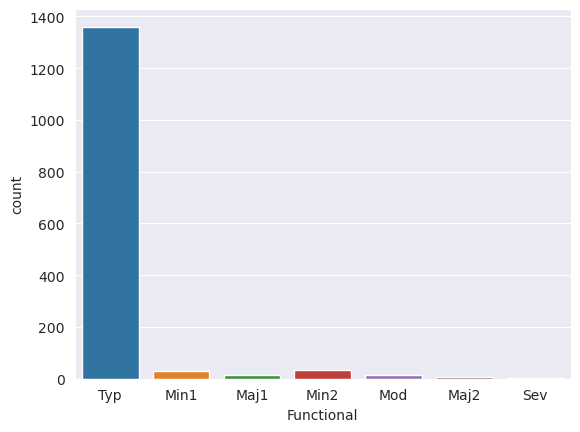

Inspected Column: Fireplaces


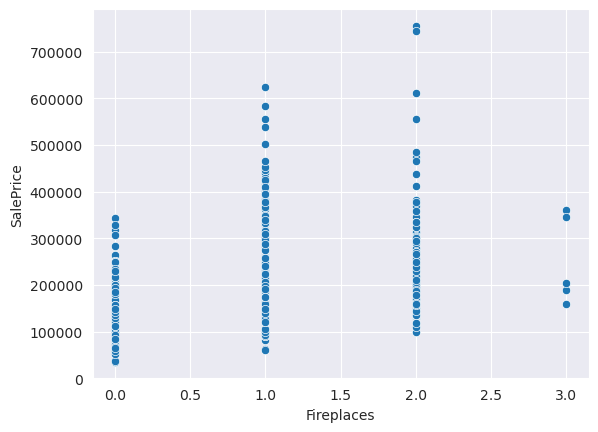

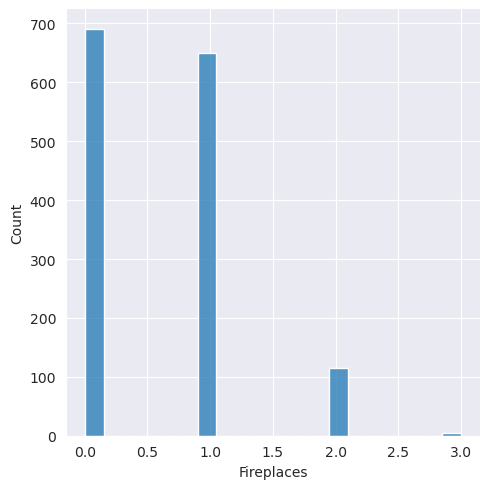

Inspected Column: FireplaceQu


Inspected Column: GarageType


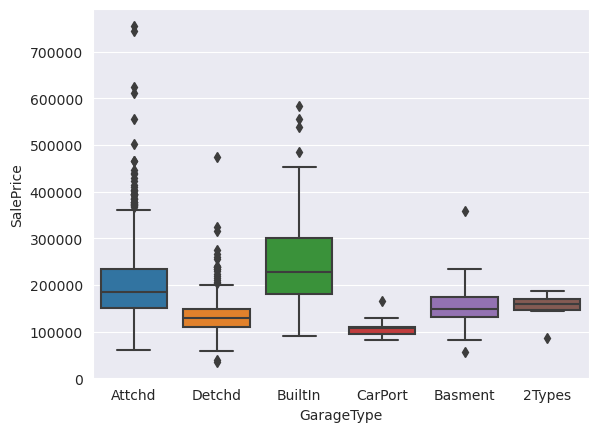

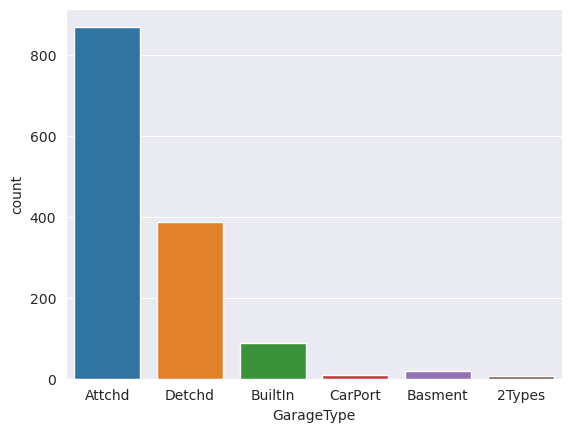

Inspected Column: GarageYrBlt


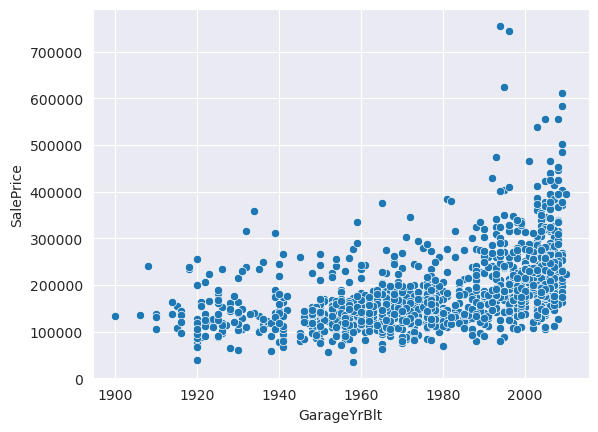

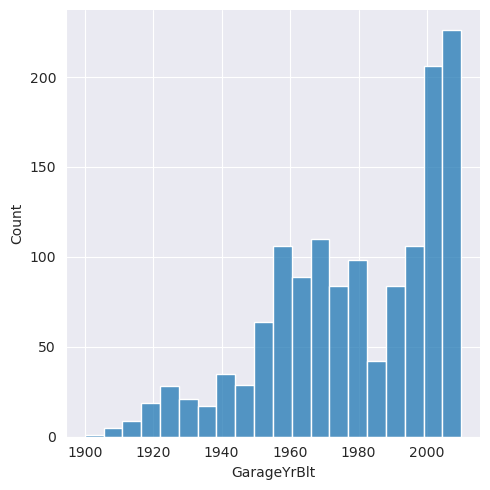

Inspected Column: GarageFinish


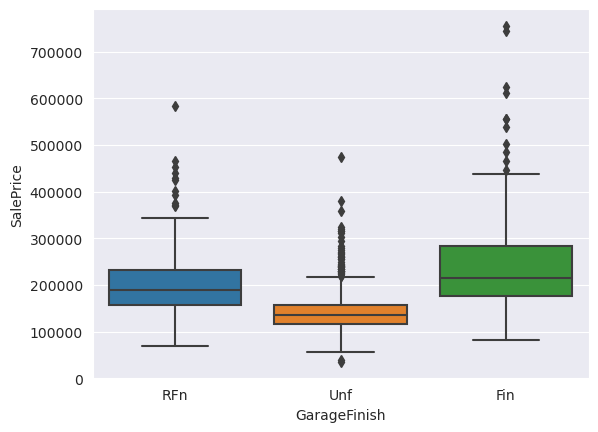

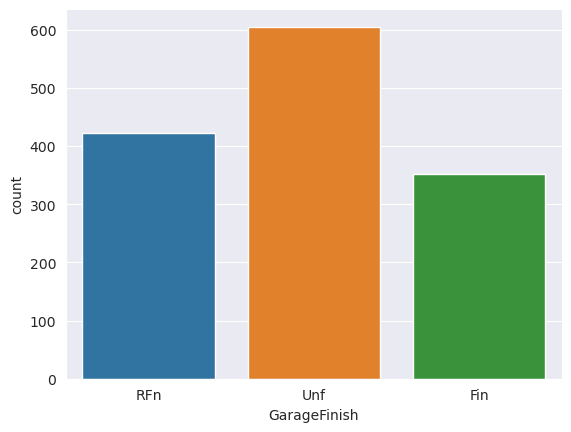

Inspected Column: GarageCars


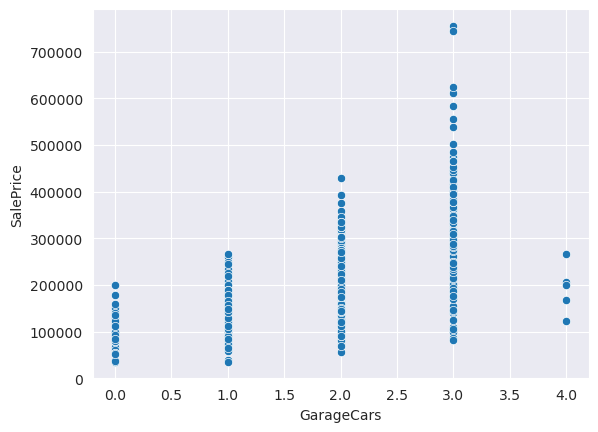

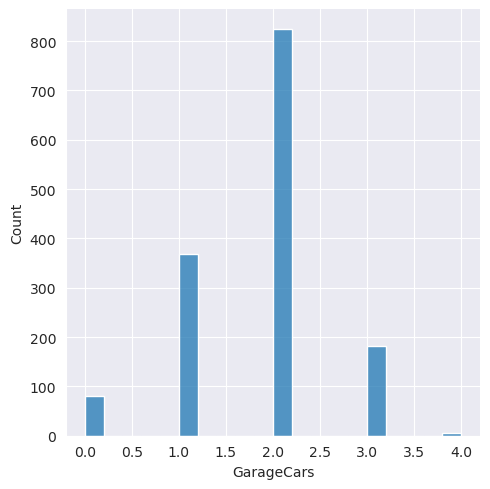

Inspected Column: GarageArea


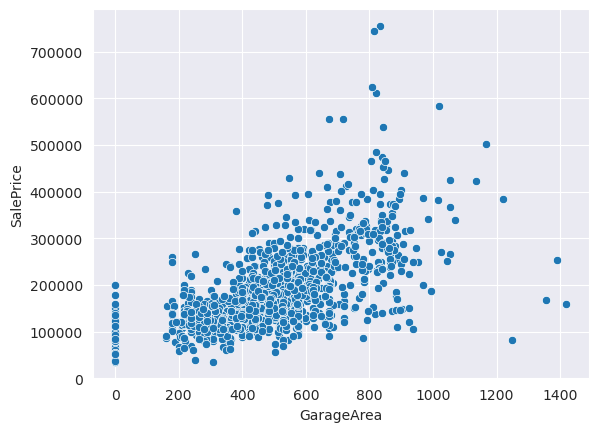

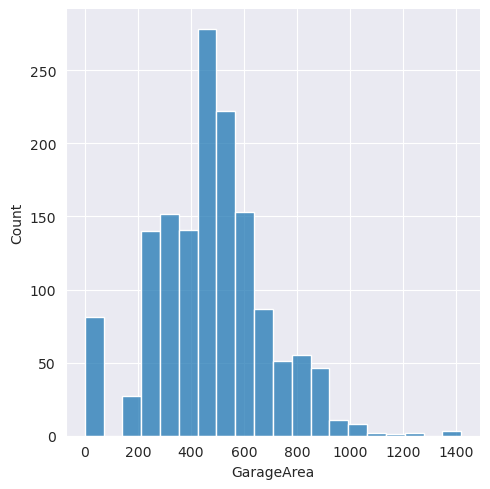

Inspected Column: GarageQual


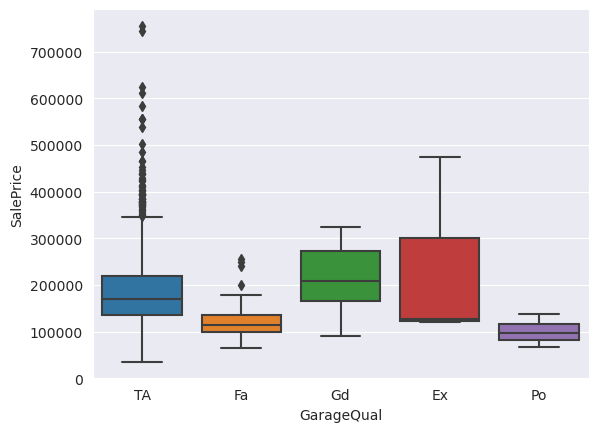

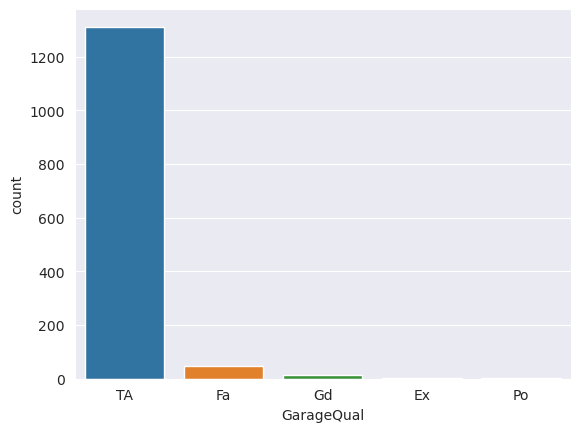

Inspected Column: GarageCond


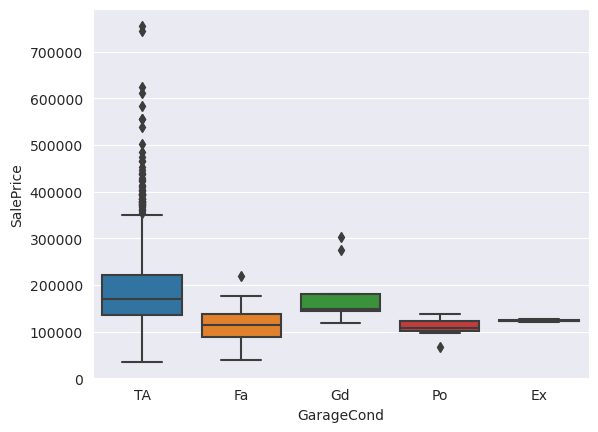

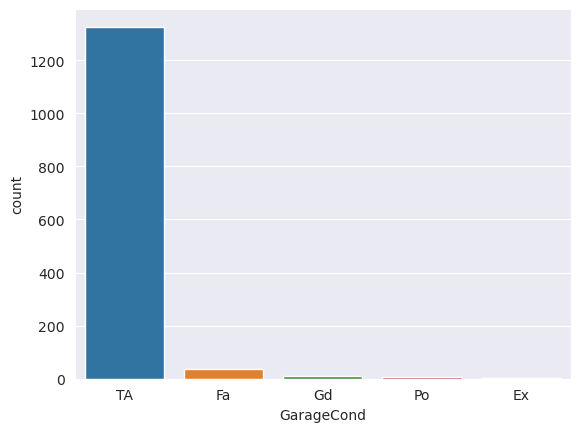

Inspected Column: PavedDrive


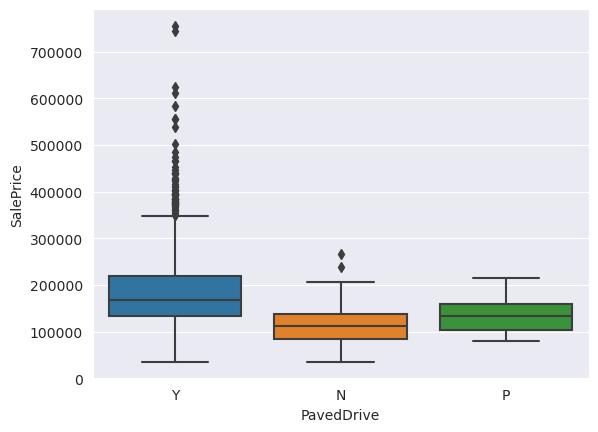

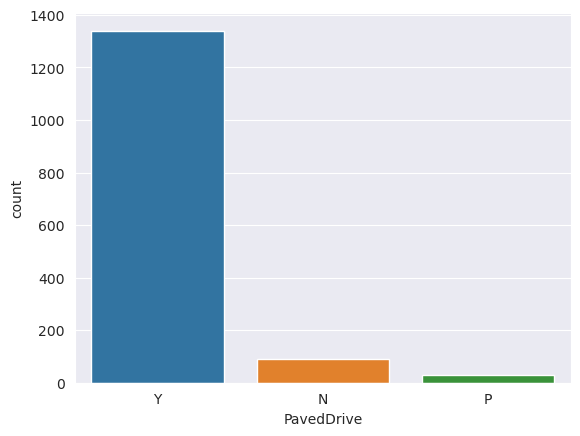

Inspected Column: WoodDeckSF


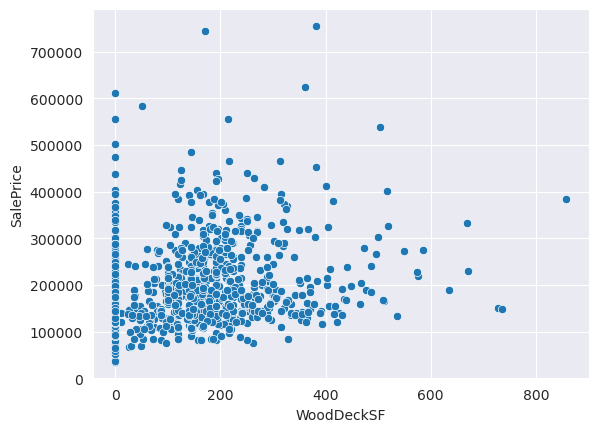

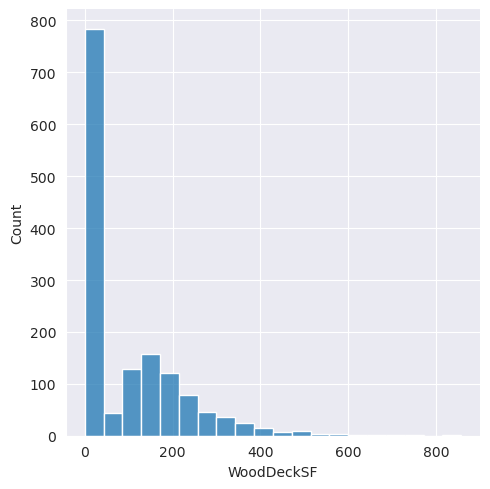

Inspected Column: OpenPorchSF


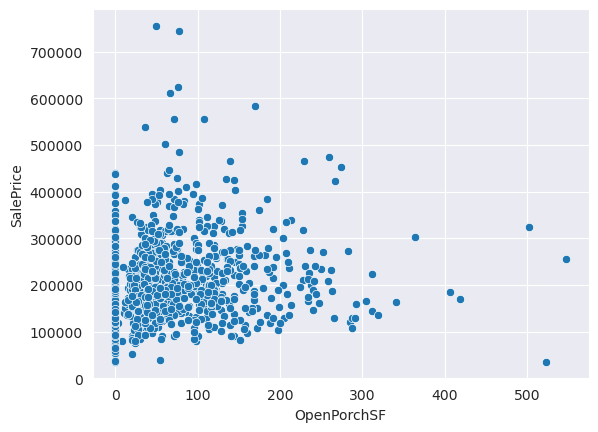

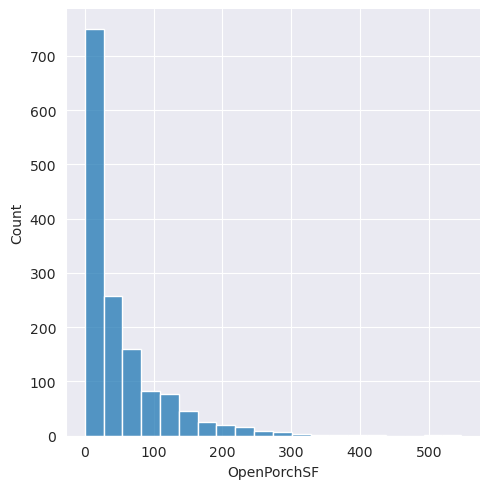

Inspected Column: EnclosedPorch


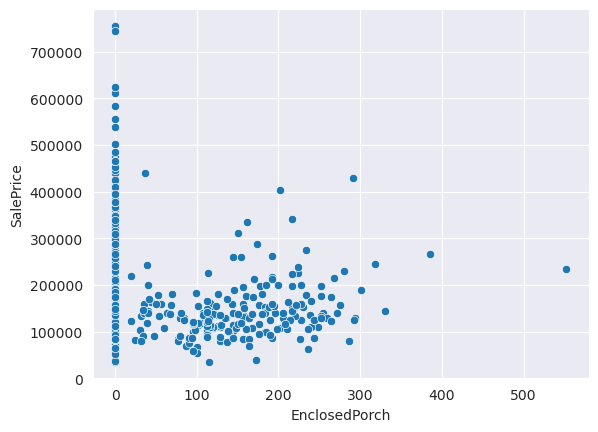

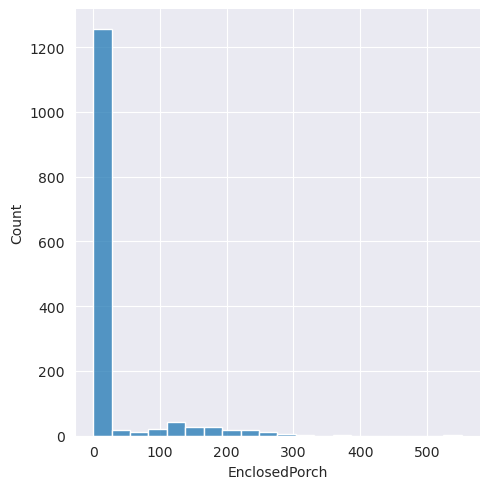

Inspected Column: 3SsnPorch


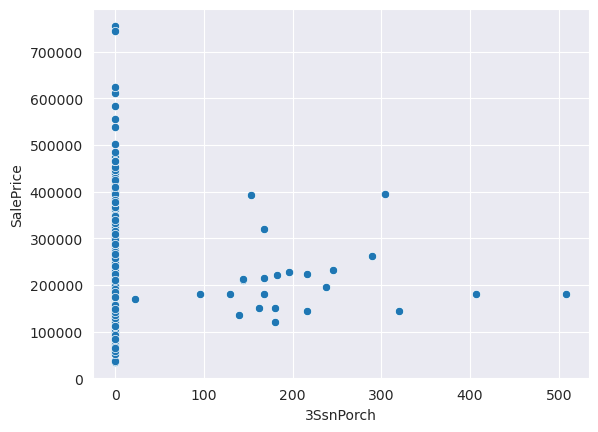

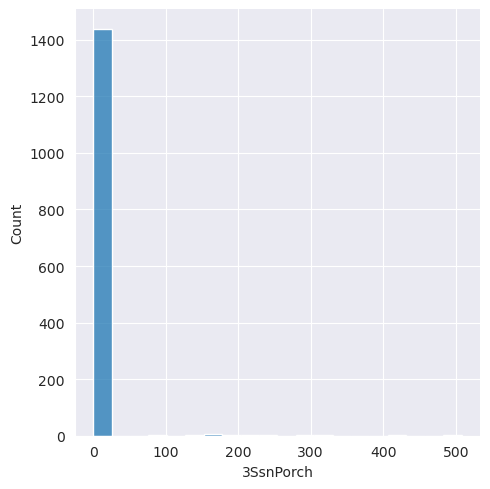

Inspected Column: ScreenPorch


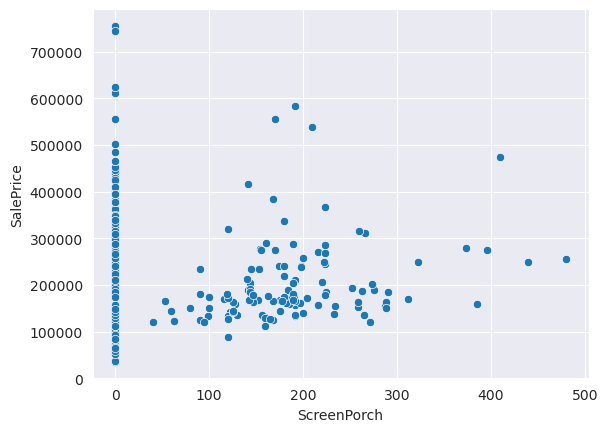

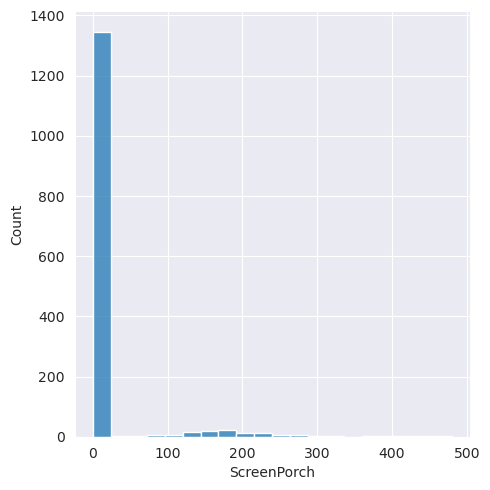

Inspected Column: PoolArea


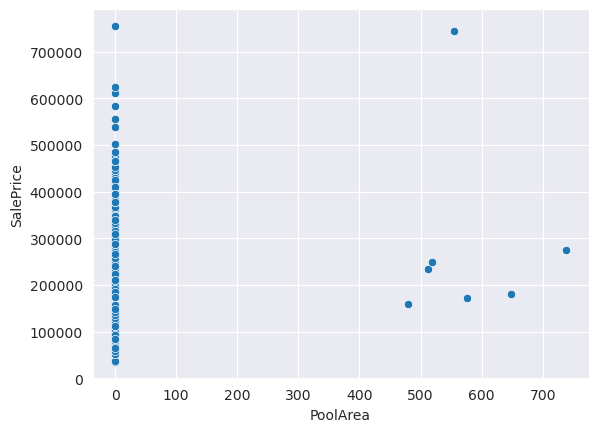

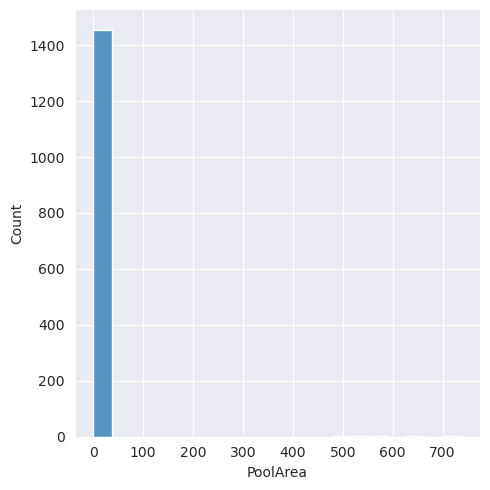

Inspected Column: PoolQC


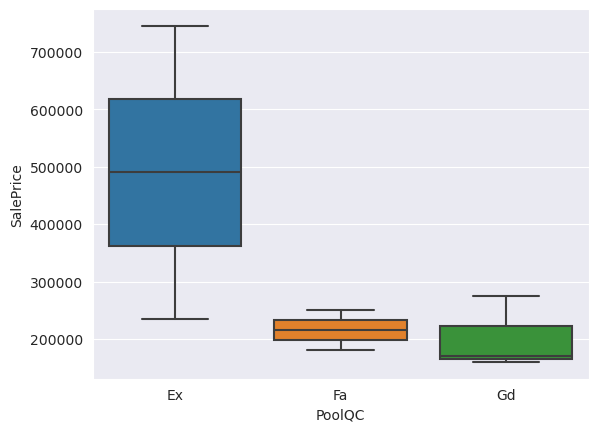

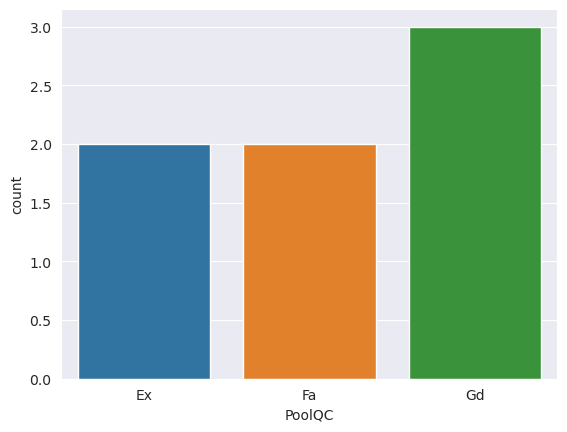

Inspected Column: Fence


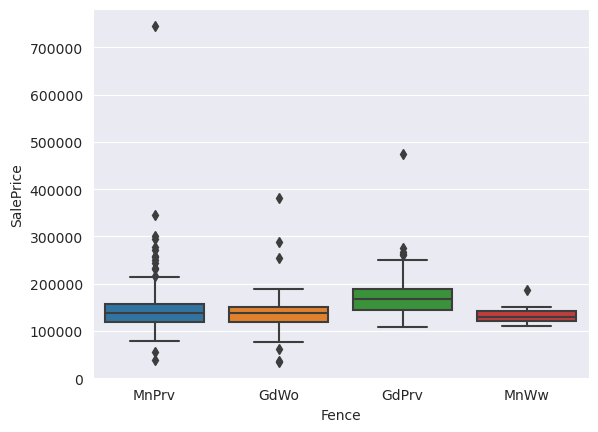

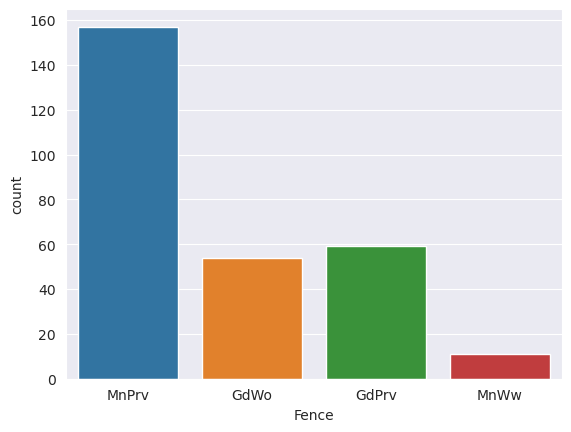

Inspected Column: MiscFeature


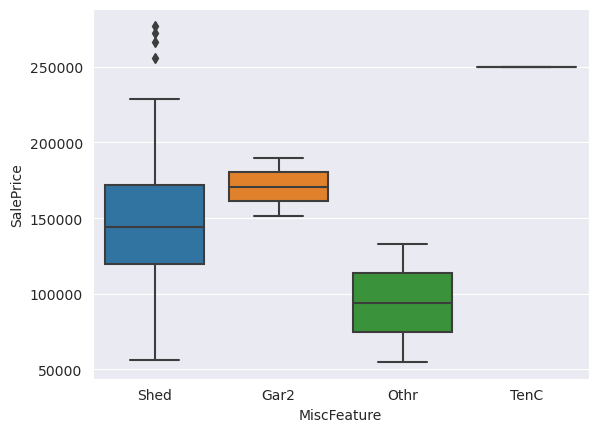

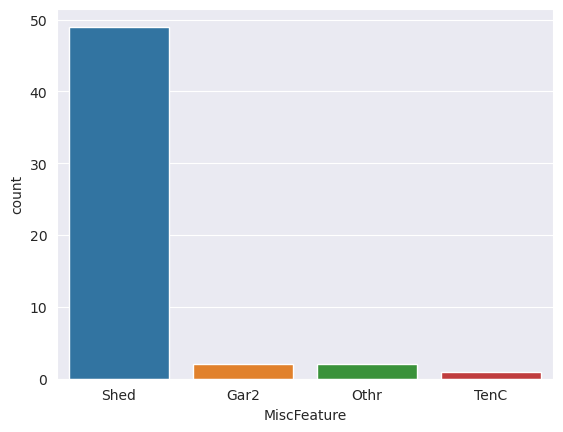

Inspected Column: MiscVal


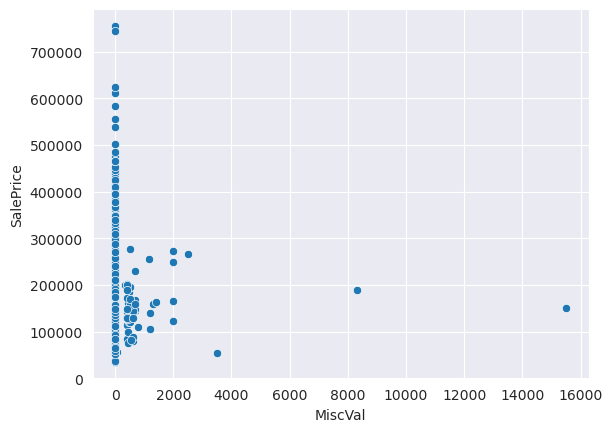

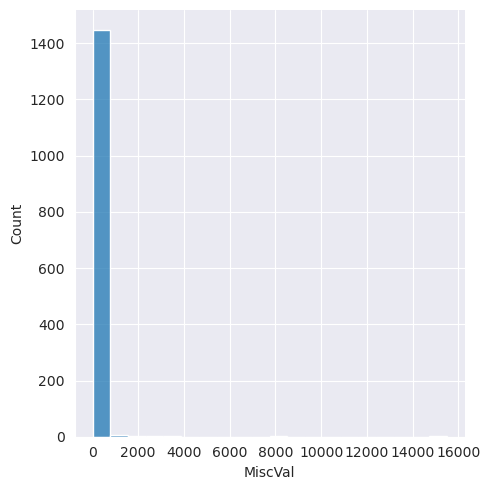

Inspected Column: MoSold


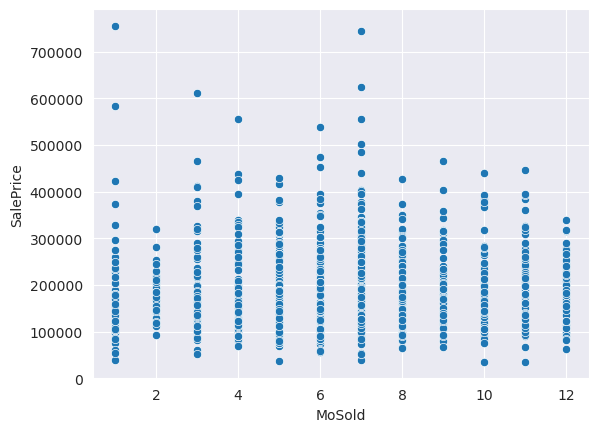

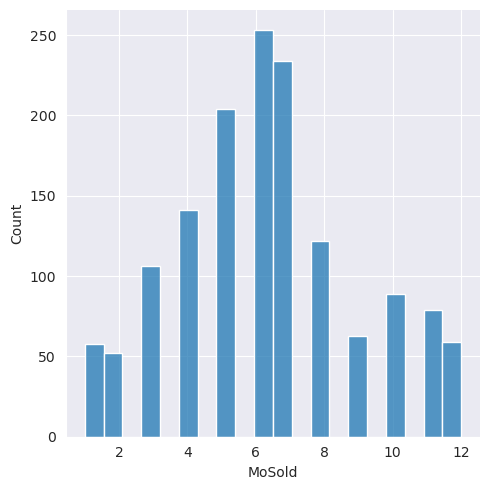

Inspected Column: YrSold


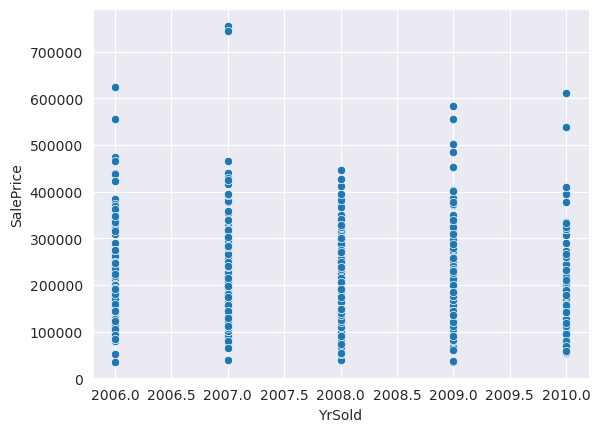

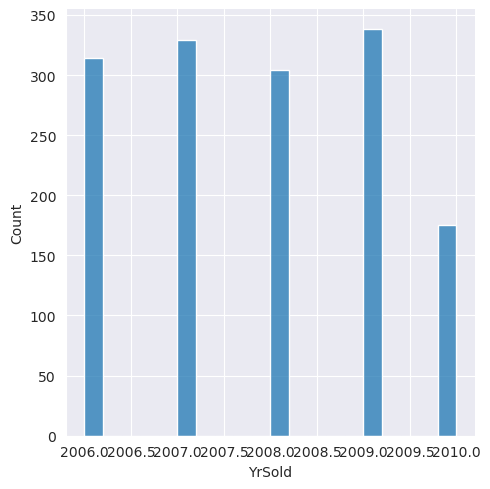

Inspected Column: SaleType


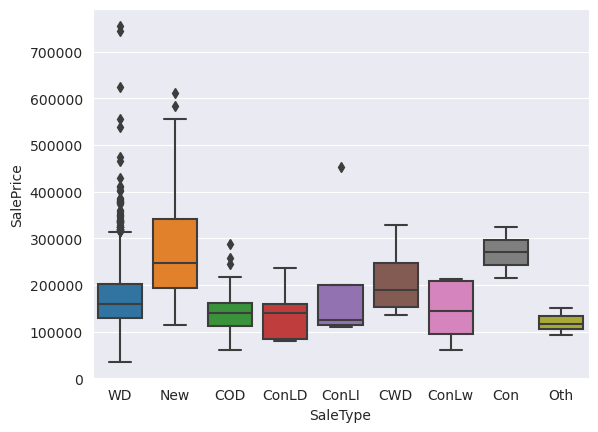

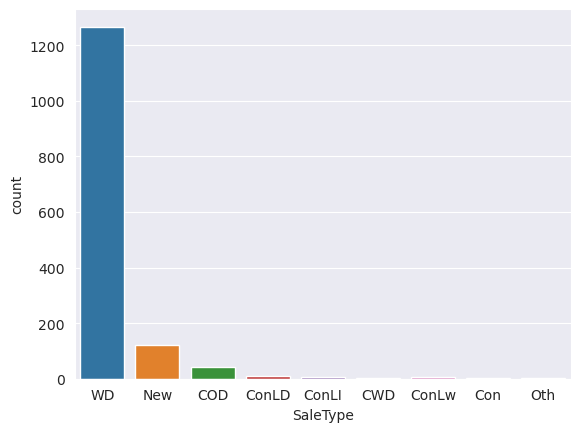

Inspected Column: SaleCondition


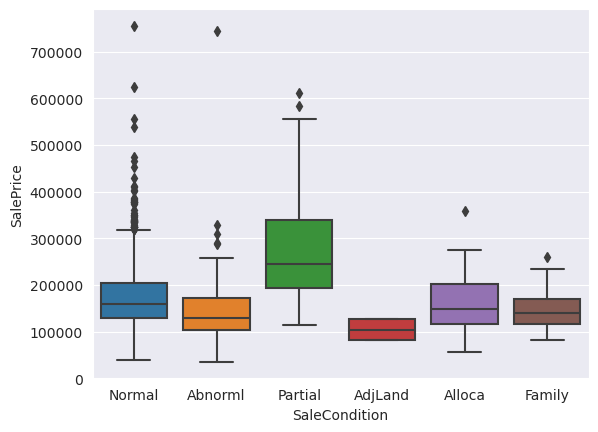

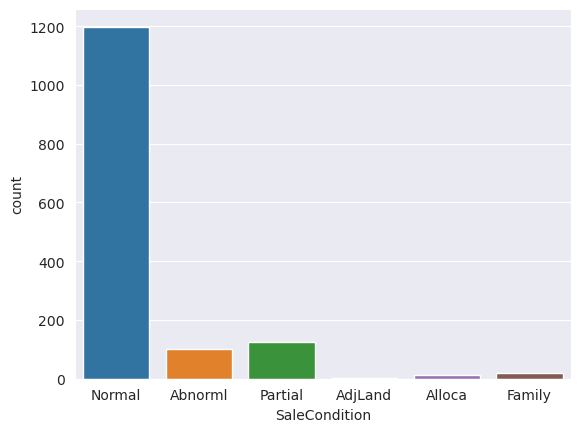

Inspected Column: SalePrice


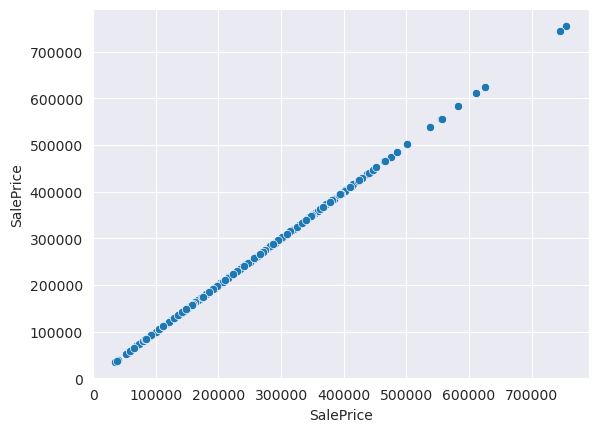

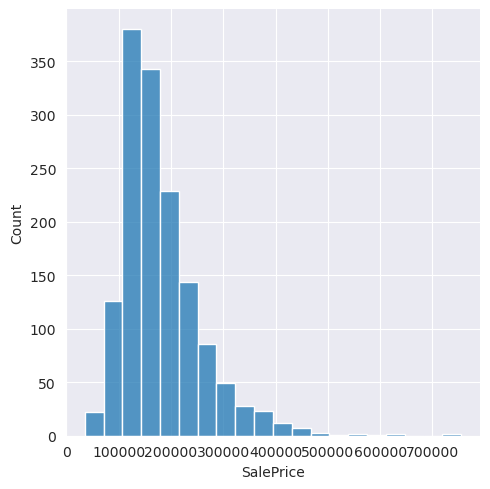

In [5]:
sns.set_style("darkgrid")
for col in train0.columns:
    if col == "Id":
        continue
        
    print("Inspected Column: "+ col)
    if col in train0.select_dtypes(include="object").columns:
        sns.boxplot(x=train0[col],y=train0["SalePrice"])
        plt.show()
        sns.countplot(x=train0[col])
        plt.show()
    else:
        sns.scatterplot(x=train0[col],y=train0["SalePrice"])
        plt.show()
        sns.displot(x=train0[col],bins=20)
        plt.show()
    print("="*80)
    print("="*80)

In [6]:
# There is a row that Garage Built Year is 2207. It is impossible and it is probably 2007 and there is a typo.

test0['GarageYrBlt'].mask(test0['GarageYrBlt'] ==2207 ,2007, inplace=True)

In [7]:
target = train0["SalePrice"] #Extract the target variable
test_ids = test0["Id"] #It will be needed for submission

#Drop id column, it does not contain any information related with sale price.
train0 = train0.drop(["Id","SalePrice"],axis=1)  
test0 = test0.drop("Id",axis=1)
#Concat
whole0 = pd.concat([train0,test0],axis=0)
train0["MSSubClass"] = train0["MSSubClass"].astype("str")
test0["MSSubClass"] = test0["MSSubClass"].astype("str")


In [8]:
train1 = train0.copy()
test1 = test0.copy()

In [9]:
#There are some meaningful missing values in certain category.
meaningful_cat = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1",
                  "BsmtFinType2","FireplaceQu","GarageType","GarageFinish",
                  "GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]
na_object_cols = list(whole0.select_dtypes("object").loc[:,whole0.isna().sum()>0].columns)

# From the data description, we know that NA in these columns are meaningful
# For example, it tells us house does not have garage.
for col in meaningful_cat:
    train1[col] = train1[col].fillna("NA")
    test1[col] = test1[col].fillna("NA")
for col in na_object_cols:
    train1[col] = train1[col].fillna(train1[col].mode()[0])
    test1[col] = test1[col].fillna(train1[col].mode()[0])



In [10]:
train2 = train1.copy()
test2 = test1.copy()

# Feature Engineering
BlttoSold: Age of house
RemodtoSold: Years after modification.
GarageAge: Age of Garage

In [11]:
train2["BlttoSold"] = train2["YrSold"]-train2["YearBuilt"]
train2["RemodtoSold"] = train2["YrSold"]-train2["YearRemodAdd"]
train2["GarageAge"] = train2["YrSold"]-train2["GarageYrBlt"]
test2["BlttoSold"] = test2["YrSold"]-test2["YearBuilt"]
test2["RemodtoSold"] = test2["YrSold"]-test2["YearRemodAdd"]
test2["GarageAge"] = test2["YrSold"]-test2["GarageYrBlt"]

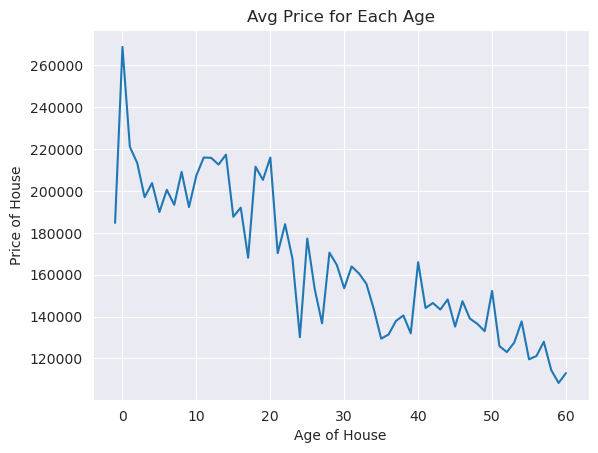

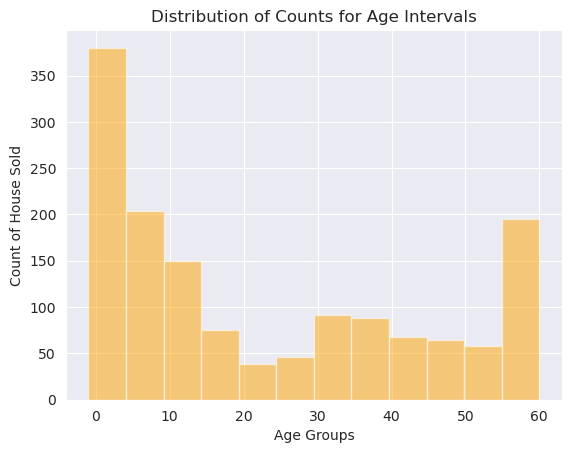

In [14]:
import matplotlib.pyplot as plt
tempdf = pd.concat([train2,target],axis=1)
tempdf.groupby("RemodtoSold")["SalePrice"].mean().plot()
plt.title("Avg Price for Each Age")
plt.ylabel("Price of House")
plt.xlabel("Age of House")
plt.show()

tempdf["RemodtoSold"].hist(bins=12,color="orange",alpha=0.5)
plt.xlabel("Age Groups")
plt.ylabel("Count of House Sold")
plt.title("Distribution of Counts for Age Intervals")
plt.show()

In [13]:
# We drop these columns since they are eighter does not contain any helpful information or data is very imbalanced that model can't learn from them. 
train2 = train2.drop(["Street", "Utilities","Condition2","RoofMatl","Heating","PoolQC","MiscFeature","MiscVal","GarageYrBlt","YearBuilt","MoSold"],axis=1)
test2 = test2.drop(["Street", "Utilities","Condition2","RoofMatl","Heating","PoolQC","MiscFeature","MiscVal","GarageYrBlt","YearBuilt","MoSold"],axis=1)

In [16]:
# There are some rows that is not accurate. We simply check and correct them.
# For example, i assume a house can't be sold before build.
# New columns "Oldness" and "CondNormal" is derived from other columns.
train2["BlttoSold"] = train2["BlttoSold"].apply(lambda x: 0 if x<0 else x)
train2["RemodtoSold"] = train2["RemodtoSold"].apply(lambda x: 0 if x<0 else x)
train2["GarageAge"] = train2["GarageAge"].apply(lambda x: 0 if x<0 else x)
test2["BlttoSold"] = test2["BlttoSold"].apply(lambda x: 0 if x<0 else x)
test2["RemodtoSold"] = test2["RemodtoSold"].apply(lambda x: 0 if x<0 else x)
test2["GarageAge"] = test2["GarageAge"].apply(lambda x: 0 if x<0 else x)
train2["Oldness"] = train2["BlttoSold"].apply(lambda x: "New" if x<=20 else("Old" if x>=50 else "Mid"))
test2["Oldness"] = test2["BlttoSold"].apply(lambda x: "New" if x<=20 else("Old" if x>=50 else "Mid"))
train2["CondNormal"]=train2["Condition1"].apply(lambda x:1 if x=="Norm" else 0)
test2["CondNormal"]=test2["Condition1"].apply(lambda x:1 if x=="Norm" else 0)

In [17]:
# I treat it like a categorical column.
train2["YrSold"]=train2["YrSold"].astype("str")
test2["YrSold"]=test2["YrSold"].astype("str")

<AxesSubplot:>

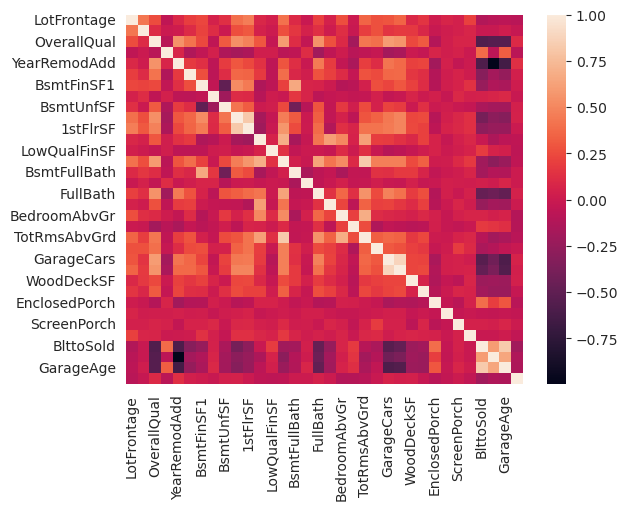

In [18]:
import seaborn as sns
sns.heatmap(train2.corr())

In [20]:
wholedf0 = pd.concat([train2,test2],axis=0)

In [21]:
# We deal with skewness. Some of the columns are right skewed, so we apply log transform to make them more linear.
# Our model learns easier when features are close to linear.
# I used log1p which is log(1+x) because there are some zeros in columns. log(0) is indefinite.
target =np.log1p(target)
numeric_features= wholedf0.select_dtypes(np.number).columns
skewed_features = train2[numeric_features].apply(lambda x: skew(x.dropna()))
# skew() calculates skew for each column 
# dropna() removes missing values 
# skew>0.5 or <0.5 means the column is skewed.
skewed_features = skewed_features[skewed_features > 0.5] 
skewed_features = skewed_features.index 
# get indices of all the skewed features 

wholedf0[skewed_features] = np.log1p(wholedf0[skewed_features]) 
# apply normalization to all of the skewed features 

In [125]:
"""Normally, we should have use this method for get_dummies
but because it is a competition rather than creating a product with
machine learning, we can use get_dummies on test and train, and then divide them

x_train = wholedf0[:train2.shape[0]]
x_test = wholedf0[train2.shape[0]:]
x_train = pd.get_dummies(x_train)
x_train = x_train.fillna(x_train.mean())
x_test = pd.get_dummies(x_test)
x_test = x_test.fillna(x_train.mean())
st=x_test.reindex(columns=x_train.columns,fill_value=0)"""


'Normally, we should have use this method for get_dummies\nbut because it is a competition rather than creating a product with\nmachine learning, we can use get_dummies on test and train, and then divide them\n\nx_train = wholedf0[:train2.shape[0]]\nx_test = wholedf0[train2.shape[0]:]\nx_train = pd.get_dummies(x_train)\nx_train = x_train.fillna(x_train.mean())\nx_test = pd.get_dummies(x_test)\nx_test = x_test.fillna(x_train.mean())\nst=x_test.reindex(columns=x_train.columns,fill_value=0)'

In [22]:
wholedf0 = pd.get_dummies(wholedf0,drop_first=True) 
x_train = wholedf0[:train2.shape[0]]
x_test = wholedf0[train2.shape[0]:]
# and we already have the value of y 

In [23]:
#I used KnnImputer to fill missing values. It finds closest 3 house and fill nan by looking them.
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
x_train = pd.DataFrame(imputer.fit_transform(x_train),columns=x_train.columns)
x_test = pd.DataFrame(imputer.transform(x_test),columns=x_test.columns)

In [24]:
# For pycaret implementation.
#s = setup(data = pd.concat([x_train,np.log1p(target)], axis=1), target = "SalePrice")

NameError: name 'setup' is not defined

In [129]:
#best = compare_models()

In [27]:

important_features = ["OverallQual","GrLivArea","TotalBsmtSF","1stFlrSF","GarageCars","RemodtoSold","FullBath","LotArea"]
x_train[important_features]= x_train[important_features]*2
x_test[important_features]= x_test[important_features]*2

# Implementation of optuna.
It is a library for hyperparameter tuning. It does it automatically. I wanted to try it and learn how to use it. GridSearchCV is expected to find the best parameter but it would be also slower.

In [134]:
"""from sklearn.model_selection import KFold, cross_val_score

def xgb_objective(trial):
    kf = KFold(n_splits=10)
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgboost.XGBRegressor(**param)
    model.fit(x_train, target)
    
    cv_scores = np.expm1(np.sqrt(-cross_val_score(model, x_train, target,
                                                scoring='neg_mean_squared_error', cv=kf)))
    return np.mean(cv_scores)"""

"from sklearn.model_selection import KFold, cross_val_score\n\ndef xgb_objective(trial):\n    kf = KFold(n_splits=10)\n    param = {\n        'max_depth': trial.suggest_int('max_depth', 1, 10),\n        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),\n        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),\n        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),\n        'gamma': trial.suggest_float('gamma', 0.01, 1.0),\n        'subsample': trial.suggest_float('subsample', 0.01, 1.0),\n        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),\n        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),\n        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),\n        'random_state': trial.suggest_int('random_state', 1, 1000)\n    }\n    model = xgboost.XGBRegressor(**param)\n    model.fit(x_train, target)\n    \n    cv_scores = np.expm1(np.sqrt(-cross_val_score(model, x_train, target,\n           

In [135]:
"""study = optuna.create_study(direction='minimize')
study.optimize(xgb_objective, n_trials=100)"""

"study = optuna.create_study(direction='minimize')\nstudy.optimize(xgb_objective, n_trials=100)"

# Ensembling Models
We use four models and use the informations from them. I gave them different coefficients. I tuned these coefficients by trying. 

In [33]:
y = target
xgb_params = {'max_depth': 2, 'learning_rate': 0.11328758518874926, 'n_estimators': 825,
            'min_child_weight': 3, 'gamma': 0.012172090378580193,
                    'subsample': 0.9445461804953733, 'colsample_bytree': 0.5115224401426094,
                            'reg_alpha': 0.32467356988924734, 'reg_lambda': 0.35152370885021267,
                                    'random_state': 999}

ba_ridge_params = {'n_iter': 144, 'tol': 0.0024980839266197465,
                       'alpha_1': 2.690470853337206, 'alpha_2': 0.17741110674748914,
                       'lambda_1': 8.55935177057469, 'lambda_2': 1.2483237905124324e-06}
xgb = xgboost.XGBRegressor(**xgb_params).fit(x_train,y)
xgb_preds = xgb.predict(x_test)

catB = CatBoostRegressor(random_state=0,verbose=0).fit(x_train,y)
catB_preds=catB.predict(x_test)

ba_ridge = BayesianRidge(**ba_ridge_params).fit(x_train,y)
ba_ridge_preds = ba_ridge.predict(x_test)

lasso = Lasso(alpha = 0.000451).fit(x_train,y)
lasso_preds=lasso.predict(x_test)

final_preds = (xgb_preds*0.1 + catB_preds*0.5 + ba_ridge_preds*0.2 + lasso_preds*0.2)
final_preds = np.expm1(final_preds)

solution = pd.DataFrame({"id":test_ids, "SalePrice":final_preds})
solution.to_csv("predictions.csv", index = False)
print(solution)

        id      SalePrice
0     1461  119324.386018
1     1462  159733.110868
2     1463  186622.528715
3     1464  198906.270817
4     1465  192183.385655
...    ...            ...
1454  2915   82562.994742
1455  2916   80682.153028
1456  2917  169388.307425
1457  2918  117651.848423
1458  2919  227832.246201

[1459 rows x 2 columns]
